<a href="https://colab.research.google.com/github/jerrywliu/ssm-diffusion/blob/main/notebooks/SSM_diff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install einops omegaconf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=a910de7fdbfda1e93903e4afb5a5733a33cb9d27c77f9d6803a5e2e56eec3ace
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
!git clone https://github.com/jerrywliu/ssm-diffusion.git

Cloning into 'ssm-diffusion'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
# Imports
%load_ext autoreload
%autoreload 2

import os
import sys

import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import datasets as sk_datasets

import torch
import torch.nn as nn
import torch.nn.functional as F

import opt_einsum as oe
from einops import rearrange, repeat

from tqdm import tqdm
from omegaconf import OmegaConf

## Visualize dataset

In [ ]:
# Config
config = """
max_epochs: 100
data:
  image_size: 32
  train_batch_size: 4
  eval_batch_size: 4  # How many images to sample during eval
optimizer:
  name: Adam
  learning_rate: 1e-4
  weight_decay: 5e-5
logging:
  save_image_epochs: 10
  save_model_epochs: 20
seed: 42
no_gpu: false
"""
config = OmegaConf.create(config)

# Device
config.device = ('cuda:0'
                 if torch.cuda.is_available() and config.no_gpu is False
                 else 'cpu')
device = torch.device(config.device)

In [ ]:
# Make a dataloader which generates these trajectories

class TwoMoonsClassic(torch.utils.data.Dataset):

    """Data Handler that creates Bouncing MNIST dataset on the fly."""

    def __init__(self, seq_len=50, n_moons=4, batch_size=256, device = "cuda:0", noise_schedule = "exp"):#, transform=transforms.Compose([torch.ToTensor()])):
        self.seq_len = seq_len
        self.noise_schedule = noise_schedule
        self.rho = 1
        if self.noise_schedule == "karras":
            self.sigma_min = 0.002
            self.sigma_max = 10
            self.t = np.power(np.power(self.sigma_max, 1/self.rho) + np.linspace(0,1,self.seq_len)*(np.power(self.sigma_min, 1/self.rho) - np.power(self.sigma_max, 1/self.rho)), self.rho)
            # TODO: d_sigma not implemented for karras
        elif self.noise_schedule == "exp":
            self.sigma_min = 1e-2
            self.sigma_max = 50
            self.t = self.sigma_max * np.exp(np.linspace(0,1,self.seq_len)*np.log(self.sigma_min/self.sigma_max))
            self.d_sigma = np.log(self.sigma_min/self.sigma_max)/self.seq_len

        self.N = 1000 # size of dataset, chosen arbitrarily
        self.moons_size = n_moons
        self.batch_size = batch_size
        self.dim = 2 # moons are 2D
        self.moons = torch.tensor(sk_datasets.make_moons(self.moons_size)[0]) # data only
        self.seed_is_set = False
        self.device = device

        print(f"Dataset length: {self.__len__()}")

    def set_seed(self, seed):
        if not self.seed_is_set:
            self.seed_is_set = True
            np.random.seed(seed)

    def __len__(self):
        return self.N

    # Simulate trajectories from the true probability flow ODE
    def __getitem__(self, index):
        self.set_seed(index)

        trajectory = []

        data_indices = np.random.choice(self.moons_size, self.batch_size, replace=True)
        ground_truth = self.moons[data_indices, :] # (batch_size x dim)
        noise = torch.randn((self.batch_size, self.dim))
        noisy = ground_truth + self.t[0]*noise # (batch_size x dim)
        trajectory.append(noisy.clone())

        for i in range(self.seq_len-1):
            # Compute d_noisy
            distances = torch.pow(torch.norm(noisy[:, None, :] - self.moons[None, :, :], dim=2), 2) # (batch_size x num_moons)
            u = distances[:, :]/(-2*self.t[i]**2) # batch x num_moons
            u_max = torch.max(u, 1).values # batch
            v = torch.exp(u - u_max[:, None]) # batch x num_moons
            v = v/torch.sum(v, 1)[:, None] # batch x num_moons
            d_noisy = self.d_sigma * (noisy - oe.contract("b n, n d -> b d", v, self.moons)) # (batch_size x dim)

            noisy += d_noisy
            trajectory.append(noisy.clone())

        return torch.stack(trajectory).swapaxes(0,1).float().to(self.device) # (seq_len x batch_size x dim)

In [ ]:
# Dataset settings
n_moons = 400
seq_len = 50
batch_size = 256

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

moon_dataset_train = TwoMoonsClassic(device = device, seq_len=seq_len, n_moons=n_moons, batch_size=batch_size)
moon_dataset_test = TwoMoonsClassic(device = device, seq_len=seq_len, n_moons=n_moons, batch_size=batch_size)

Dataset length: 1000
Dataset length: 1000


True dataset distribution:

Dataset shape: (400, 2)


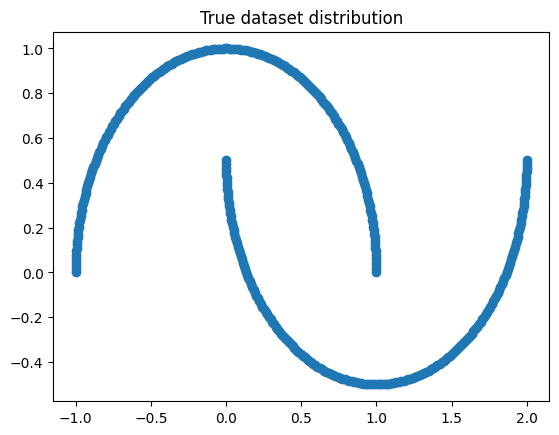

In [ ]:
# Visualize true data distribution
#moon_dataset_train = TwoMoonsClassic(device = device)
moons_true = moon_dataset_train.moons.numpy()
print(f"Dataset shape: {moons_true.shape}")
plt.scatter(moons_true[:, 0], moons_true[:, 1])
plt.title("True dataset distribution")
plt.show()

Example probability flow ODE trajectories. Note how each trajectory has roughly three phases: starting from pure noise, headed straight toward the dataset mean; then a nonlinear part; then mostly straight toward the final data point.

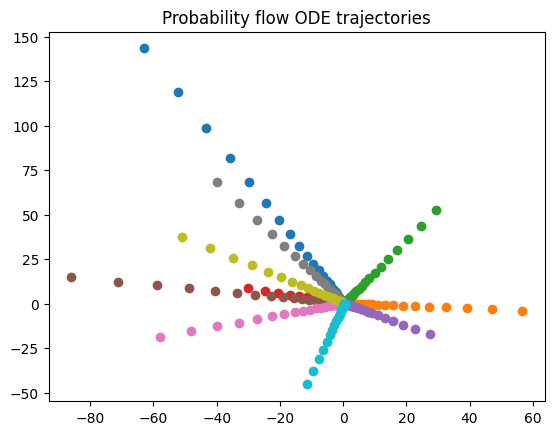

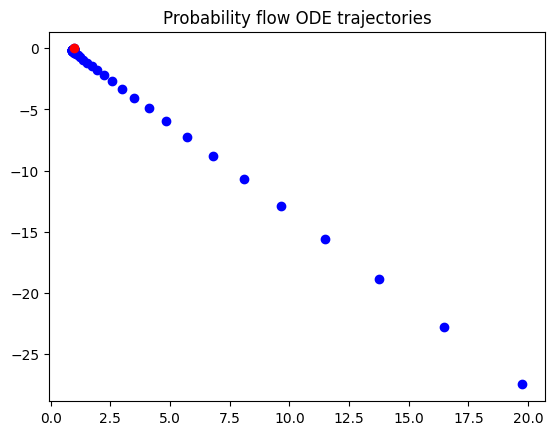

In [ ]:
# Visualize true ODE trajectory
viz_trajectories = 10

for train_traj_i, train_traj in enumerate(moon_dataset_train):
    for data_i in range(train_traj.shape[0]):
        if data_i == viz_trajectories:
            break
        plt.scatter(train_traj[data_i, :, 0].cpu(), train_traj[data_i, :, 1].cpu())
    plt.title("Probability flow ODE trajectories")
    plt.show()
    break

# Visualize a single trajectory
viz_trajectories = 1

for train_traj_i, train_traj in enumerate(moon_dataset_train):
    for data_i in range(train_traj.shape[0]):
        if data_i == viz_trajectories:
                break
        plt.scatter(train_traj[data_i, :, 0].cpu(), train_traj[data_i, :, 1].cpu(), color="blue")
        plt.scatter(train_traj[data_i, -1:, 0].cpu(), train_traj[data_i, -1:, 1].cpu(), color="red")
    plt.title("Probability flow ODE trajectories")
    plt.show()
    break

Finally, the samples from our probability flow ODE, solved with N=seq_len timesteps and specified noise scheduler.

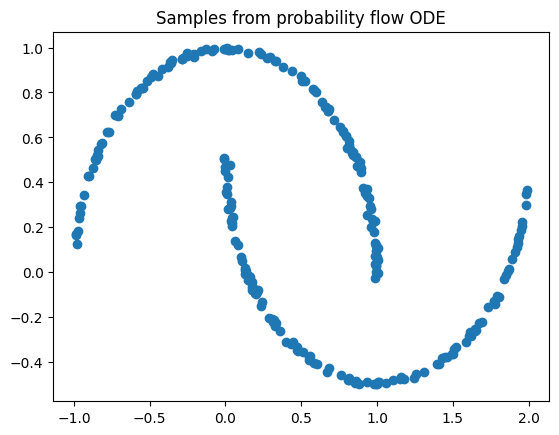

In [ ]:
# Visualize ODE endpoints
plt.scatter(train_traj[:, -1, 0].cpu(), train_traj[:, -1, 1].cpu())
plt.title("Samples from probability flow ODE")
plt.show()

## Model

We want to train an autoregressive model $f$ that takes as input a portion of a sample probability flow ODE trajectory $x_0, \dots, x_{n-1}$, where $x_0$ is pure noise, and outputs $x_n$, for any $n \leq N$ ($N$ = max sequence length). To do generation, we'll sample noise $x_0$, then obtain $\hat{x_1} = f(x_0)$, $\hat{x_2} = f(x_0, \hat{x_1})$, $\dots$, $\hat{x_N} = f(x_0, \dots, \hat{x_{N-1}})$. The sample we end up with will be $\hat{x_N}$.

Model in this notebook is a sequence-to-sequence model parameterized using SSMs, that takes as input $x_0, \dots, x_{N-1}$ and learns to output the sequence $x_1, \dots, x_N$, where $x_N$ is the final (completely denoised) sample. The SSMs will be causal, which means the $i$-th output should only depend on the first $i$ inputs. Furthermore, thanks to the nice properties of SSMs, during generation, we can directly output the whole sequence $\hat{x_1}, \dots, \hat{x_N}$ given input $x_0$. See the SpaceTime paper for a reference here (closed-loop SSMs).

Model architecture:
- Optional encoder, mapping data to high dimensions
- Stack of SSMs
    - Among the stack of SSMs, we need one "closed-loop" SSM that outputs a full length-$N$ output $(y_1, \dots, y_N)$ given a (potentially shorter) input sequence $(x_0, \dots, x_i)$, $0 \leq i \leq N-1$. The rest of the SSMs can be standard "open-loop" SSMs whose outputs are the same length as their inputs.
- Optional decoder, mapping high dimensional space back to original domain

SSM Kernels (different parameterizations)

In [ ]:
def krylov(L, A, b, c=None, return_power=False):
    """
    Compute the Krylov matrix (b, Ab, A^2b, ...) using the squaring trick.

    If return_power=True, return A^{L-1} as well
    """
    # TODO There is an edge case if L=1 where output doesn't get broadcasted, which might be an issue if caller is expecting broadcasting semantics... can deal with it if it arises

    x = b.unsqueeze(-1) # (..., N, 1)
    A_ = A

    AL = None
    if return_power:
        AL = torch.eye(A.shape[-1], dtype=A.dtype, device=A.device)
        _L = L-1

    done = L == 1
    # loop invariant: _L represents how many indices left to compute
    while not done:
        if return_power:
            if _L % 2 == 1: AL = A_ @ AL
            _L //= 2

        # Save memory on last iteration
        l = x.shape[-1]
        if L - l <= l:
            done = True
            _x = x[..., :L-l]
        else: _x = x

        _x = A_ @ _x
        x = torch.cat([x, _x], dim=-1) # there might be a more efficient way of ordering axes
        if not done: A_ = A_ @ A_

    try:
        assert x.shape[-1] == L
    except:
        print('x.shape', x.shape)
        print('L', L)
        breakpoint()

    if c is not None:
        x = torch.einsum('...nl, ...n -> ...l', x, c)
    x = x.contiguous() # WOW!!
    if return_power:
        return x, AL
    else:
        return x

In [ ]:
class OurModule(nn.Module):
    """
    Interface for Module that allows registering buffers/parameters
    with configurable optimizer hyperparameter
    - from S4 code: https://github.com/HazyResearch/state-spaces/blob/main/src/models/s4/s4.py
    """
    def __init__(self):
        super().__init__()

    def register(self,
                 name: str,
                 tensor: torch.FloatTensor,
                 trainable: bool=False,
                 lr: float=None,
                 wd: float=None):
        """
        Utility method: register a tensor as a buffer or trainable parameter
        """
        if trainable:
            try:
                self.register_parameter(name, nn.Parameter(tensor))
            except KeyError:
                delattr(self, name)
                self.register_parameter(name, nn.Parameter(tensor))
        else:

            try:
                self.register_buffer(name, tensor)
            except KeyError:
                delattr(self, name)
                self.register_buffer(name, tensor)

        optim = {}
        if trainable and lr is not None: optim["lr"] = lr
        if trainable and wd is not None: optim["weight_decay"] = wd
        if len(optim) > 0: setattr(getattr(self, name), "_optim", optim)


class Kernel(OurModule):
    def __init__(self,
                 d_kernel,
                 n_heads,
                 n_channels,  # 1
                 skip_connection,
                 closed_loop,
                 train,
                 inference_only=False):
        super().__init__()

        self.d_kernel   = d_kernel
        self.n_heads    = n_heads
        self.n_channels = n_channels

        self.skip_connection = skip_connection
        self.closed_loop     = closed_loop
        self.requires_grad   = train
        self.inference_only  = inference_only

        self._fp = (self.n_channels, self.n_heads, self.d_kernel)

    def fft_conv(self, u, v):
        L   = u.shape[-1]
        u_f = torch.fft.rfft(u, n=2*L) # (B H L)
        v_f = torch.fft.rfft(v, n=2*L) # (C H L)

        y_f = oe.contract('b h l, c h l -> b c h l', u_f, v_f)
        y   = torch.fft.irfft(y_f, n=2*L)[..., :L] # (B C H L)
        return y

    def fft_conv_d(self, u, v):  # Used to get hidden state
        # Can we do this more efficiently so we don't have to compute D x D hidden-state?
        L   = u.shape[-1]
        u_f = torch.fft.rfft(u, n=2*L, dim=2).unsqueeze(-1) # (B H L 1)
        v_f = torch.fft.rfft(v, n=2*L, dim=3).unsqueeze(-1) # (C H D L 1)

        y_f = oe.contract('b h l i, c h d l i -> b c h l d', u_f, v_f)
        y   = torch.fft.irfft(y_f, n=2*L, dim=3)[:, :, :, :L, :] # (B C H L D)
        return y

    def init_weights(self):
        raise NotImplementedError('Call in child class')

    def forward(self, u):
        raise NotImplementedError('Call in child class')


In [ ]:
class CompanionKernel(Kernel):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Initialize trainable parameters
        self.init_weights()

        # Shift matrix initialization
        self.shift_matrix = torch.zeros(self.n_channels,
                                        self.n_heads,
                                        self.d_kernel,
                                        self.d_kernel)
        self.shift_matrix[:, :, 1:, :-1] = torch.eye(self.d_kernel - 1)
        self.a_padding = torch.zeros(*self._fp)
        self.a_padding[:, :, -1] = 1.

    def init_weights(self):
        # A, B, C, D matrices are trainable by default
        trainable = True if self.requires_grad is True else False

        # A matrix
        a = torch.randn(*self._fp)
        self.register("a", a, trainable, lr=None, wd=None)

        # B matrix
        b = torch.randn(*self._fp)  # learn_b is True
        self.register("b", b, trainable, lr=None, wd=None)

        # C matrix
        c = torch.randn(*self._fp)  # learn_c is True
        self.register("c", c, trainable, lr=None, wd=None)

        # D matrix (skip connection) - learn_d is True
        # if self.skip_connection:
        d = torch.randn(self.n_channels, self.n_heads)
        self.register("d", d, trainable, lr=None, wd=None)

    def norm(self, x, ord=1):
        # x.shape = C x H x D
        x_norm = torch.linalg.norm(x, ord=ord, dim=2, keepdim=True)
        x = x / x_norm  # if x_norm[:, 0].item() != 0 else x
        return x

    def matrix_power(self, l, c, b, a):
        ch, h, d = b.shape
        # Construct companion matrix
        A = self.shift_matrix.to(a.device) + oe.contract(
            'c h i, c h j -> c h j i',  self.a_padding.to(a.device), a
        )
        # Use repeated squares
        g = krylov(l, A, b, c)  # Need to import
        return g

    def get_hidden_state(self, l, u):
        # a, b, c.shape is C x H x D
        a = self.norm(self.a, ord=self.norm_ord)
        k = self.matrix_power(l, None, self.b, a) # C x H x D x L
        x = self.fft_conv_d(u, k)  # B x C x H x L x D
        return x

    def get_kernel(self, u, c, l):
        a = self.norm(self.a, ord=1)
        k = self.matrix_power(l, c, self.b, a).to(u.device)
        return k

    def convolve(self, u, c):
        l = u.size(-1)
        f = self.get_kernel(u, c, l)
        y = self.fft_conv(u, f)
        return y

    def forward(self, u, n_hidden_state: int=0):
        # Input shape is (B, H, L)
        # n_hidden_state is ignored
        y = self.convolve(u, c=self.c)
        if self.skip_connection:
            y = y + oe.contract('b h l , c h -> b c h l', u, self.d)
        # We now output multiple outputs
        return rearrange(y, 'b c h l -> b (c h) l'), None


In [ ]:
class ShiftKernel(CompanionKernel):
    def __init__(self, n_hidden_state, **kwargs):
        self.n_hidden_state = n_hidden_state
        self.target_length = None
        super().__init__(**kwargs)

    def init_weights(self):
        # A matrix ix fixed shift matrix
        A = torch.zeros(self.n_channels, self.n_heads,
                        self.d_kernel, self.d_kernel)
        A[:, :, 1:, :-1] = torch.eye(self.d_kernel - 1)
        self.register("A", A, trainable=False, lr=None, wd=None)

        # B matrix is fixed
        b    =  torch.zeros(self.d_kernel).float()
        b[0] = 1.
        b    = repeat(b, 'd -> c h d',
                      c=self.n_channels, h=self.n_heads).clone().contiguous()
        self.register("b", b, trainable=False, lr=None, wd=None)

        # C, K, D matrices are trainable by default
        trainable = True if self.requires_grad is True else False

        c = torch.randn(*self._fp)
        self.register("c", c, trainable, lr=None, wd=None)

        if self.closed_loop:
            k = torch.randn(*self._fp)
            self.register("k", k, trainable, lr=None, wd=None)

        # D matrix (skip connection) is trainable
        d = torch.randn(self.n_channels, self.n_heads)
        self.register("d", d, trainable, lr=None, wd=None)

    def matrix_power(self, l, c, b, a=None):
        ch, h, d = b.shape
        # Use repeated squares
        g = krylov(l, self.A, b, c)  # Need to import
        return g

    def get_hidden_state(self, l, u):
        """
        Currently not called
        """
        # u.shape is C x H x D
        k = self.matrix_power(l, None, self.b, self.a) # C x H x D x L
        x = self.fft_conv_d(u, k)  # B x C x H x L x D
        return x

    def get_kernel(self, u, c=None, l=None):
        l = u.size(-1) if l is None else l
        c = self.c if c is None else c
        k = self.matrix_power(l, c, self.b, self.a).to(u.device)
        return k

    def convolve(self, u, A, l, c=None):
        c = self.c if c is None else c
        f = krylov(l, A, self.b, c)
        y = self.fft_conv(u, f)
        y = rearrange(y, 'b c h l -> b (c h) l')
        return y

    def recurse_hidden_state(self, u, A, l, n_hidden_state):
        # Compute hidden state
        f = krylov(n_hidden_state, A, self.b, None)
        x  = self.fft_conv_d(u, f)
        BK = oe.contract('c h i, c h j -> c h i j', self.b, self.k)
        x  = krylov(L=l - n_hidden_state,
                    A=A + BK,
                    b=x[:, :, :, n_hidden_state - 1, :],
                    c=None)
        return x

    def norm(self, x, ord=1):
        # x.shape = C x H x D
        x_norm = torch.linalg.norm(x, ord=ord, dim=2, keepdim=True)
        x = x / x_norm
        return x

    def forward(self, u):
        ch, h, d = self.b.shape
        b,  d, l = u.shape

        # Inference
        if self.target_length is not None: l = self.target_length

        # Outputs
        y, y_, u_ = None, None, None

        if self.closed_loop:
            # Can also compute from just first hidden_state = B * e, e ~ N(0, I)
            # - Then also only initialize the A + BK:
            #   - Once for each sample during training
            #   - Once for all samples during test  (Faster)

            # Compute A = (A + BK)^i for i in [0, ..., n - 1]

            # Hacks for stabilization right now
            k = self.norm(self.k.clamp(1 / 16, 1), ord=1)
            BK = oe.contract('c h i, c h j -> c h i j', self.b, k)
            # Compute 1st hidden state: x_1 = Bu_0
            x1 = oe.contract('b h l, c h l -> b c h l', u[:, :, 0].view(b, d, 1), self.b)
            x1 = rearrange(x1, 'b c h l -> b (c h) l')
            # Compute CBu, C(A + BK)x_1, ..., C(A + BK)^(l-1)x_1
            y  = krylov(l, self.norm(self.A + BK), x1, c=self.c)

            # # Old way to do this (memory-wise more expensive because initializes hidden-state x?
            # # But twice as slow bc does computation twice
            # # Also repeats the original hidden_state
            # x = self.recurse_hidden_state(u, A, l, self.n_hidden_state)
            # y = torch.einsum('...nl, ...n -> ...l', x, self.c).contiguous()
            # y = rearrange(y, 'b c h l -> b (c h) l')

            # During training, compute closed-loop outputs and open-loop outputs
            if not self.inference_only:
                # u_ = torch.einsum('...nl, ...n -> ...l', x, self.k).contiguous()
                # u_ = rearrange(u_, 'b c h l -> b l (c h)')  # Save 1 extra rearrange
                u_ = krylov(l, self.norm(self.A + BK), x1, c=self.k)  # B H L

                # Compute open-loop
                y_ = self.convolve(u, self.A, l)  # .cpu()  # Move back to gpu before loss
        else:
            y = self.convolve(u, self.A, l)

        # Return:
        # 1. Closed-loop output prediction (if closed-loop, else open-loop)
        # 2. 2nd-to-last layer prediction
        # 3. Open-loop output prediction
        return y, u_, y_  # y, z[0], z[1]


In [ ]:
class DiagKernel(Kernel):
    """
    Numerical quadrature integration with trapezoid rule
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.learn_a     = self.requires_grad
        self.kernel_train = self.requires_grad

        # Settings from DSS: hardcode to default
        self.use_initial = False
        self.trap_rule   = True
        self.learn_theta = False
        self.theta_scale = False
        self.learn_dt    = False
        self.dt_min      = 0.001
        self.dt_max      = 0.1
        self.constrain_a = True

        self.kernel_weights = None
        self.lr = None

        # Init weights
        self.init_weights()

    def init_weights(self):
        # Set skip connection
        if self.kernel_weights is not None:
            # lr and wd as None means they're the same as model lr and wd
            self.register('k', self.kernel_weights, trainable=True, lr=None, wd=None)

        skip = torch.randn(self.n_heads)
        self.register('skip', skip, trainable=True, lr=None, wd=None)

        # Only learn half the elements due to complex conjugacy
        self.param_shape = (self.n_heads, self.d_kernel // 2)

        # For quadrature
        self.order2const = {1 : [], 2: [1/2], 3: [5/12,13/12], 4: [3/8,7/6,23/24]}

        # Initialize b, c, x[0]
        if self.use_initial:
            self.b  = nn.Parameter(torch.randn(*self.param_shape))
            self.c  = nn.Parameter(torch.randn(*self.param_shape))
            self.x0 = nn.Parameter(torch.randn(*self.param_shape))
        else:
            self.q  = nn.Parameter(torch.randn(*self.param_shape))

        # Initialize a and theta weights (Chebyshev initialization)
        h_scale  = torch.exp(torch.arange(self.n_heads) / self.n_heads *
                             math.log(self.dt_max / self.dt_min))
        angles   = torch.arange(self.d_kernel // 2) * math.pi
        t_scale  = h_scale if self.theta_scale else torch.ones(self.n_heads)
        theta    = oe.contract('n, d -> nd', t_scale, angles)
        a        = -repeat(h_scale, 'nk -> nk kd',
                           kd=self.d_kernel // 2).clone().contiguous()

        self.register("theta", theta, self.learn_theta, lr=self.lr, wd=None)
        self.register("a", a, self.learn_a, lr=self.lr, wd=None)

        if self.learn_dt:
            log_T = torch.rand(self.n_heads) * (
                math.log(self.dt_max) - math.log(self.dt_min)
            ) + math.log(self.dt_min)
            self.register("log_T", log_T, True, lr=self.lr, wd=None)


    def numerical_quadrature(self, f, g, order=3):
        # From HazyResearch:
        # this is old C-numerical recipe here looks like
        # http://www.foo.be/docs-free/Numerical_Recipe_In_C/c4-1.pdf
        # int_a^b = T*[1/2*f_1  + f_2 + ... + f_{n-1} + 1/2*f_n]
        # order 3 = T*[5/12*f_1 + 12/13f_2 + f_3 + ... f_{n-2} + 12/13*f_{n-1} + 5/12*f_n]
        # order 4 = T*[3/8*f_1  + 7/6*f_2 + 23/24*f_3 ... + f_{n-3} + f_{n-2}*23/24 + 7/6*f_{n-1}+3/8*f_n]
        # These formulas differ are manipulated so that for all but the endpoints, it's just adding them up!
        # Compare with typical simpson's composite rule that requires multiplying intermediate values.
        #
        # BE WARNED. The encapsulation on this is terrible, we rely on orders of f and g -- and T is premultiplied into f
        # it needs a serious refactor and it caused pain.
        #
        # Order here refers to the error term being of order say O(N^{-3}) for order 3
        #
        y = self.fft_conv(g, f)
        # g.shape is batch x model_dim (= n_heads) x len

        # y[k] = T*sum_{j} g[k-j]f[j] = T*sum_{j} h_k[j]
        # NB: F is pre-multiplied with T?
        def _roll(h,j): return h[..., :-j] if j > 0 else h

        for i, c in enumerate(self.order2const[order]):
            # roughly what we want is:
            # y[i:] += T*(c-1)*(h[i] + h[:-i]) where -0 is understood to mean h itself, which is not python
            # so the indexing here is we want
            # g[k-i]f[i] which means we need to shift g up by i positions.
            # term = _roll(g,i)*f[...,i] + g[...,i]*_roll(f,i)
            term  = oe.contract('h, b h l -> b h l', f[..., i], _roll(g, i))
            term += oe.contract('h l, b h -> b h l', _roll(f, i), g[..., i])
            #y[...,i:] += T*(c-1)*term
            y[..., i:] += (c - 1) * term # Note: f is premultiplied with T.
        return y

    def fft_conv(self, u_input: torch.tensor, v_kernel: torch.tensor,
                 L: int=None):
        # Convolve u with v in O(n log n) time with FFT (n = len(u))
        L   = u_input.shape[-1] if L is None else L # Assume u is input
        u_f = torch.fft.rfft(u_input, n=2*L) # (B H L)
        v_f = torch.fft.rfft(v_kernel[:, :L], n=2*L) # (H L)

        y_f = oe.contract('b h l, h l -> b h l', u_f, v_f)
        y   = torch.fft.irfft(y_f, n=2*L)[..., :L]  # (B H L)
        return y

    def set_weights(self, name, weights, trainable, lr=None, wd=None):
        w = getattr(self, name)
        assert w.shape == weights.shape
        self.register(name, weights, trainable, lr, wd)

    def get_kernel(self, u, l=None):
        # Input u should be (B, n_kernels, L)
        l = u.size(-1) if l is None else l
        # Step size
        if self.learn_dt:
            T = torch.exp(self.log_T).view(-1, 1, 1)
        else:
            T = 1 / (l - 1)

        zk = T * torch.arange(l, device=u.device).view(1, -1, 1)  # zk.shape is (1, L, 1)
        _a = -self.a.abs() if self.constrain_a else self.a        # _a.shape is (nk, kd // 2)
        base_term = (2 * T * torch.exp(_a.unsqueeze(1) * zk) *
                     torch.cos(self.theta.unsqueeze(1) * zk))     # base_term.shape is (nk, L, kd // 2)
        q  = self.b * self.c if self.use_initial else self.q      # q.shape is (nk, kd // 2)
        f  = (q.unsqueeze(1) * base_term).sum(-1)                 # f.shape is (nk, L)
        return f

    def forward(self, u, l=None):
        # For the sake of usage in SSDLayer, assume u is input as B X D (=H) x L
        # u = rearrange(u, 'b l d -> b d l')  # Assume u is B x L x D
        k = self.get_kernel(u, l)
        y = self.numerical_quadrature(k, u, order=2 if self.trap_rule else 1)

        # Add in the skip connection with per-channel D matrix
        if self.skip_connection:
            y = y + oe.contract('b h l, h -> b h l', u, self.skip)
        # Add back the initial state
        if self.use_initial:
            y = y + (2 * (self.c * self.x0).unsqueeze(2) * base_term).sum(-1)
        # Again, for sake of usage in SSDLayer, assume output is B X D X L
        return y, None
        # return rearrange(y, 'b d l -> b l d')


Encoder/decoder variants

In [ ]:
class RepeatEncoder(nn.Module):
    def __init__(self,
                 input_dim:   int,
                 output_dim:  int,
                 input_shape: str='bld'):
        """
        Repeats inputs along a certain dimension D by output_dim // D
        """
        super().__init__()
        self.input_dim     = input_dim
        self.output_dim    = output_dim
        self.input_shape   = input_shape

        self.initialize_layers()

    def initialize_layers(self):
        pass

    def forward(self, x):
        if self.input_shape == 'bdl':
            x = repeat(x, 'b d l -> b (r d) l',
                       r=self.output_dim // x.shape[1])
            x = rearrange(x, 'b d l -> b l d')
        else:
            x = repeat(x, 'b l d -> b l (r d)',
                       r=self.output_dim // x.shape[2])
        return x

In [ ]:
class DenseEncoder(nn.Module):
    def __init__(self,
                 input_dim:      int,
                 output_dim:     int,
                 activation:     str=None,
                 dropout:        float=0.,  # Not implemented yet
                 n_layers:       int=1,
                 n_activations:  int=0,
                 pre_activation: bool=False,
                 input_shape:    str='bld',
                 hidden_dim:     int=None):
        """
        Fully-connected network
        """
        super().__init__()
        self.input_dim     = input_dim
        self.hidden_dim    = hidden_dim
        self.output_dim    = output_dim
        self.input_shape   = input_shape

        if activation == "gelu":
            self.activation = nn.GELU()
        self.dropout        = None  # DropoutNd
        self.n_layers       = n_layers
        self.n_activations  = n_activations
        self.pre_activation = pre_activation

        self.initialize_layers()

    def initialize_layers(self):
        n_layers_to_init = self.n_layers
        n_activations_to_init = self.n_activations

        if self.hidden_dim is None:  # Probs not great, but implicitly handle
            self.hidden_dim = self.output_dim

        # Add layers
        if self.n_activations > self.n_layers or self.pre_activation:
            layers = [self.activation]
            n_activations_to_init -= 1
        else:
            layers = []

        while n_layers_to_init > 0 or n_activations_to_init > 0:
            if n_layers_to_init == self.n_layers:
                layers.append(nn.Linear(self.input_dim, self.hidden_dim))
            elif n_layers_to_init > 1:
                layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
            elif n_layers_to_init == 1:
                layers.append(nn.Linear(self.hidden_dim, self.output_dim))

            if n_activations_to_init > 0:
                layers.append(self.activation)

            n_layers_to_init -= 1
            n_activations_to_init -= 1

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.input_shape == 'bdl':
            x = rearrange(x, 'b d l -> b l d')
        return self.layers(x)

In [ ]:
class ConvEncoder(OurModule):
    """
    Preserves the input dimensions
    """
    def __init__(self,
                 n_kernels:     int,  # L or seq len of input, if smaller than L, when initializing the kernel we repeat
                 d_kernel:      int,  # D or number of heads of prior SSM output, "global" conv / full kernel
                 bias:          bool=False,
                 bidirectional: bool=True,
                 input_shape:   str='bdl'):
        super().__init__()

        self.n_kernels     = n_kernels
        self.d_kernel      = d_kernel  # kernel size
        self.bias          = bias
        self.bidirectional = bidirectional
        self.input_shape   = input_shape

        self._fp = (1, self.n_kernels, self.d_kernel)  # C L D of prior input

        self.init_weights(_id='_a')
        if self.bidirectional:
            self.init_weights(_id='_b')

    def init_weights(self, _id: str='_a'):
        weight = torch.randn(*self._fp)
        self.register(f'weight{_id}', weight, train=True, lr=None, wd=None)
        if self.bias:
            bias = torch.randn(1, self.n_kernels, 1)
        else:
            bias = torch.zeros(1, self.n_kernels, 1)
        self.register(f'bias{_id}', bias, train=self.bias, lr=None, wd=None)

    def get_kernel(self,
                   u: torch.FloatTensor,
                   kernel_weights: torch.FloatTensor,
                   l: int=None) -> torch.FloatTensor:
        """
        Initialize kernel
        - u: input, assume shape is B x D x L
        """
        b, h, _l = u.shape
        l = _l if l is None else l
        weights = repeat(kernel_weights, 'c n d -> c (r n) d', r = h // self.n_kernels)
        k = F.pad(u, pad=(0, l - weights.shape[-1], 0, 0), value=0)
        return k

    def fft_conv(self, u, v):
        """Convolution via FFT from S4"""
        L   = u.shape[-1]
        u_f = torch.fft.rfft(u, n=2 * L) # B x H x L
        v_f = torch.fft.rfft(v, n=2 * L) # C x H x L

        y_f = oe.contract('bhl, chl -> bchl', u_f, v_f)
        y   = torch.fft.irfft(y_f, n=2 * L)[..., :L] # B x C x H x L
        return y

    def forward(self, u):
        # Input u shape is (B, H, L)
        b, h, l = u.shape
        k = self.get_kernel(u, self.weights_a)
        bias = repeat(self.bias_a, 'c n d -> c (r n) (l d)',
                      r=h // self.n_kernels, l=l)
        y = self.fft_conv(u, k) + bias

        if self.bidirectional:
            _k = self.get_kernel(u, self.weight_b)
            _bias = repeat(self.bias_b, 'c n d -> c (r n) (l d)',
                           r=h // self.n_kernels, l=l)
            y = self.fft_conv(torch.flip(u, [-1]), _k) + _bias

        return y


In [ ]:
class IdentityEncoder(nn.Module):
    def __init__(self, **args):
        super().__init__()
        self.initialize_layers()

    def initialize_layers(self):
        self.layers = nn.Identity()

    def forward(self, x):
        return self.layers(x)

In [ ]:
class SSDLayer(nn.Module):
    def __init__(self,
                 kernel: dict,
                 decoder: dict,
                 skip_connection: bool,
                 closed_loop: bool):
        super().__init__()
        self.kernel_args     = kernel
        self.decoder_args    = decoder
        self.skip_connection = skip_connection
        self.closed_loop     = closed_loop

        self.kernel  = self.get_kernel()
        self.decoder = self.get_decoder()

        self.inference_only = False

        # Bug with shape matching
        # assert self.skip_connection is False

    # Kernel
    def get_kernel(self):
        if self.kernel_args['type'] == 'companion':
            kernel_class = CompanionKernel
        elif self.kernel_args['type'] == 'shift':
            kernel_class = ShiftKernel
        elif self.kernel_args['type'] == 'diag':
            kernel_class = DiagKernel
        else:
            raise NotImplementedError(f"Error: {self.kernel_args['type']} not implemented")
        return kernel_class(**self.kernel_args['kwargs'])

    # Decoder
    def get_decoder(self):
        if self.decoder_args['type'] == 'repeat':
            decoder_class = RepeatEncoder
        elif self.decoder_args['type'] == 'dense':
            decoder_class = DenseEncoder
        elif self.decoder_args['type'] == 'convolution':
            decoder_class = ConvEncoder
        elif self.decoder_args['type'] == 'identity':
            decoder_class = IdentityEncoder
        else:
            raise NotImplementedError(f"Error: {self.decoder_args['type']} not implemented")
        return decoder_class(**self.decoder_args['kwargs'])

    def forward(self, u):
        # Assume input shape is (B, L, H)
        v = rearrange(u, 'b l h -> b h l')
        try:
            y, *_ = self.kernel(v)
        except:
            y = self.kernel(v)  # could output multiple, so should modify this

        y = rearrange(y, 'b h l -> b l h')
        y = self.decoder(y)
        if self.skip_connection:
            y += u
        return y


In [ ]:
class SSD(nn.Module):
    def __init__(self, config, input_config, output_config):
        super().__init__()
        self.encoder_config = config.encoder
        self.decoder_config = config.decoder
        self.rollout_config = config.rollout
        self.input_encoder_config = input_config
        self.input_decoder_config = output_config

        self.input_encoder, self.encoder, self.decoder, self.rollout, self.input_decoder = self.init_layers()

    def _init_encoder(self, encoder_args):
        if encoder_args['type'] == 'repeat':
            encoder_class = RepeatEncoder
        elif encoder_args['type'] == 'dense':
            encoder_class = DenseEncoder
        elif encoder_args['type'] == 'convolution':
            encoder_class = ConvEncoder
        elif encoder_args['type'] == 'identity':
            encoder_class = IdentityEncoder
        else:
            raise NotImplementedError(f"Error: {encoder_args['type']} not implemented")
        return encoder_class(**encoder_args['kwargs'])

    def init_layers(self):
        encoder = []
        decoder = []
        rollout = []

        for ix, layer_config in enumerate(self.encoder_config):
            encoder.append(SSDLayer(**layer_config.layer))
        for ix, layer_config in enumerate(self.decoder_config):
            decoder.append(SSDLayer(**layer_config.layer))
        for ix, layer_config in enumerate(self.rollout_config):
            rollout.append(SSDLayer(**layer_config.layer))

        encoder = nn.Sequential(*encoder)
        decoder = nn.Sequential(*decoder)
        rollout = nn.Sequential(*rollout)

        input_encoder = self._init_encoder(self.input_encoder_config)
        input_decoder = self._init_encoder(self.input_decoder_config)

        return input_encoder, encoder, decoder, rollout, input_decoder

    def set_inference_length(self, length: int):
        """
        Use during evaluation to rollout up to specified length
        """
        for ix in range(len(self.ssd_decoder)):
            self.rollout[ix].kernel.target_length = length

    def set_inference_only(self, mode: bool=False):
        """
        Use during evaluation to only go through rollout branch
        """
        self.inference_only = mode
        self.requires_grad  = not mode  # Not implemented

    def sample_noise(self, z, noise_schedule):
        # z is shape B x L x D
        noise = torch.randn_like(z)
        var   = repeat(noise_schedule, 'l -> (l r)', r=self.noise_stride)
        noise = oe.contract('b l d, l -> b l d', noise, var)
        return noise

    def compute_rollout(self, z):
        # Compute rollout with closed-loop SSM
        z = self.rollout(z)
        return z

    def forward(self, u):
        # u is shape B x L x D
        z = self.encoder(self.input_encoder(u))
        # Compute closed-loop rollout
        z_rollout = self.compute_rollout(z)
        # rollout is a prediction for future samples, so keep first input sample
        z_rollout = torch.cat([z[:, :1, :], z_rollout[:, :-1, :]], dim=1)
        y_rollout = self.input_decoder(self.decoder(z_rollout))

        if not self.inference_only:
            # During training, can also compute outputs from available inputs
            y = self.input_decoder(self.decoder(z))
        else:
            y = None

        return y_rollout, y, z_rollout, z


## Model configs (these definitely need to be tuned)

In [ ]:
ssd_heads = 128

In [ ]:
input_encoder_config = f"""
type: dense
kwargs:
  input_dim: 2
  output_dim: {ssd_heads}
  activation: gelu
  n_layers: 2
  n_activations: 1
  input_shape: bld
"""
input_encoder_config = OmegaConf.create(input_encoder_config)

In [ ]:
input_decoder_config = f"""
type: dense
kwargs:
  input_dim: {ssd_heads}
  output_dim: 2
  activation: gelu
  n_layers: 2
  n_activations: 1
  input_shape: bld
"""
input_decoder_config = OmegaConf.create(input_decoder_config)

In [ ]:
ssd_encoder_config = f"""
encoder:
- layer:
    kernel:
      type: companion
      kwargs:
        d_kernel: 16
        n_heads: {ssd_heads}
        n_channels: 1
        skip_connection: true
        closed_loop: false
        train: true
    decoder:
      type: dense
      kwargs:
        input_dim: {ssd_heads}
        output_dim: {ssd_heads}
        activation: gelu
        n_layers: 2
        n_activations: 1
    skip_connection: true
    closed_loop: false
- layer:
    kernel:
      type: companion
      kwargs:
        d_kernel: 16
        n_heads: {ssd_heads}
        n_channels: 1
        skip_connection: true
        closed_loop: false
        train: true
    decoder:
      type: dense
      kwargs:
        input_dim: {ssd_heads}
        output_dim: {ssd_heads}
        activation: gelu
        n_layers: 2
        n_activations: 1
    skip_connection: true
    closed_loop: false
"""
ssd_encoder_config = OmegaConf.create(ssd_encoder_config)

In [ ]:
ssd_decoder_config = f"""
decoder:
- layer:
    kernel:
      type: companion
      kwargs:
        d_kernel: 16
        n_heads: {ssd_heads}
        n_channels: 1
        skip_connection: true
        closed_loop: false
        train: true
    decoder:
      type: dense
      kwargs:
        input_dim: {ssd_heads}
        output_dim: {ssd_heads}
        activation: gelu
        n_layers: 2
        n_activations: 1
    skip_connection: true
    closed_loop: false
- layer:
    kernel:
      type: companion
      kwargs:
        d_kernel: 16
        n_heads: {ssd_heads}
        n_channels: 1
        skip_connection: true
        closed_loop: false
        train: true
    decoder:
      type: identity
      kwargs:
        input_dim: {ssd_heads}
        output_dim: {ssd_heads}
    skip_connection: true
    closed_loop: false
"""
ssd_decoder_config = OmegaConf.create(ssd_decoder_config)

In [ ]:
ssd_rollout_config = f"""
rollout:
- layer:
    kernel:
      type: shift
      kwargs:
        d_kernel: 16
        n_heads: {ssd_heads}
        n_channels: 1
        n_hidden_state: 1
        skip_connection: false
        closed_loop: true
        train: true
    decoder:
      type: identity
      kwargs:
        input_dim: {ssd_heads}
        output_dim: {ssd_heads}
    skip_connection: true
    closed_loop: True
- layer:
    kernel:
      type: diag
      kwargs:
        d_kernel: 16
        n_heads: {ssd_heads}
        skip_connection: true
        n_channels: 1
        closed_loop: false
        train: true
    decoder:
      type: dense
      kwargs:
        input_dim: {ssd_heads}
        output_dim: {ssd_heads}
        activation: gelu
        n_layers: 2
        n_activations: 1
    skip_connection: true
    closed_loop: false
"""
ssd_rollout_config = OmegaConf.create(ssd_rollout_config)

In [ ]:
ssd_config = OmegaConf.merge(ssd_encoder_config, ssd_decoder_config, ssd_rollout_config)

## Train (messy)

In [ ]:
def train(model, autoencoder, epoch, **kwargs):
    model.train()
    model.set_inference_only(False)
    return run_epoch(model, autoencoder, True, epoch, **kwargs)


def evaluate(model, autoencoder, epoch, **kwargs):
    model.eval()
    model.set_inference_only(mode=True)

    with torch.no_grad():
        return run_epoch(model, autoencoder, False, epoch, **kwargs)

In [ ]:
# def run_epoch(model, autoencoder, train, epoch, dataloader, scheduler,
def run_epoch(model, autoencoder, train, epoch, dataloader,
              optimizer, criterion, beta_weight_loss, device):

    model.zero_grad()
    pbar = tqdm(dataloader, leave=False)

    mean_loss = []
    closed_loss = []
    open_loss = []
    decoder_loss = []

    for ix, images in enumerate(pbar):
        #print("Batch id: ", ix)
        #inputs, outputs = images
        inputs = images
        b = inputs.shape[0]
        moons_input = inputs[0,:,:-1,:] #+ 0
#         moons_input[:,:,:2] += torch.randn_like(moons_input[:,:,:2]) * 0.05

        moons_output_1 = inputs[0,:,1:,:] # Next step

        sigma_data = 1.

        y_rollout, y, z_rollout, z = model(moons_input)

#         pred_c, pred_o = model(moons_input)
        #pred_c = pred_c[:,:,:2]
        #pred_o = pred_o[:,:,:2]

        #loss_c_1 = criterion(pred_c[:,:,:2] + moons_input[:,:,:2], moons_output_1) # *((t*t + sigma_data*sigma_data)/(t*t*sigma_data*sigma_data)) # Add loss weighting
        #loss_c_1 = criterion(pred_c[:,:,:2], moons_output_1)
        #loss_o = criterion(pred_o, moons_output)
        #loss_c_2 = criterion(pred_c[:,:,2:], moons_output_2)
        #loss = loss_c + loss_o
        # loss = loss_c_1 #+ loss_c_2

        loss_c = ((y_rollout[:, :, :] - moons_output_1[:, :, :])**2).mean() # Loss: outputs of full model vs. true trajectories
        loss_o = ((z_rollout - z)**2).mean() # Loss: train closed loop to match open loop
        loss_d = ((y[:, :, :] - moons_output_1[:, :, :])**2).mean() # Loss: outputs of encoder/decoder vs. true
        loss = loss_c + loss_o + loss_d

#         loss_c = (((pred_c[:,:,:2] - moons_output_1)**2) * (1. / (moons_input[:,:,2:]**0.1 + 0.25))).mean()
#         loss_o = (((pred_o[:,:,:2] - moons_output_1)**2) * (1. / (moons_input[:,:,2:]**0.1 + 0.25))).mean()
#         loss = loss_c + loss_o

#         loss_c = (((pred_c[:,:,:2] - moons_output_1)**2) * (1. / (moons_input[:,:,2:]**0.1 + 0.25))).mean()
#         loss_o = (((pred_o[:,:,:2] - moons_output_1)**2) * (1. / (moons_input[:,:,2:]**0.1 + 0.25))).mean()
#         loss = loss_c + loss_o

        # loss = criterion(pred, smmnist_noise)*((t*t + 0.5*0.5)/(t*t*0.5*0.5)) # Add loss weighting
        #if ix % 10 == 0:
        #    print(ix, t, loss)

        if train:
            loss.backward()
            optimizer.step()
            model.zero_grad()

        pbar_desc = f'Batch: {ix}/{len(dataloader)} | {loss}'
        pbar.set_description(pbar_desc)
        mean_loss.append(loss.detach())
        closed_loss.append(loss_c.detach())
        open_loss.append(loss_o.detach())
        decoder_loss.append(loss_d.detach())
    mean_loss = torch.tensor(mean_loss)
    print(f"Epoch loss: {torch.mean(mean_loss)}, closed: {torch.mean(torch.tensor(closed_loss))}, open: {torch.mean(torch.tensor(open_loss))}, decoder: {torch.mean(torch.tensor(decoder_loss))}")
    return

In [ ]:
model = SSD(ssd_config, input_encoder_config, input_decoder_config).to(device)

In [ ]:
train_loader = torch.utils.data.DataLoader(moon_dataset_train, batch_size=batch_size,
                                           shuffle=True)
eval_loader = torch.utils.data.DataLoader(moon_dataset_test, batch_size=batch_size,
                                          shuffle=False)

In [ ]:
from torch.optim import Adam, SGD

# seed_everything(config.seed)
criterion = nn.MSELoss(reduction='mean')

optim_config = {
    'lr': 1e-3,   # 1e-4
    'weight_decay': 0 # 5e-5 # 0
}
optimizer = Adam(model.parameters(), **optim_config)

train_config = {
    'dataloader': train_loader,  # Fill-in / update below
    # 'scheduler': scheduler,
    'optimizer': optimizer,
    'criterion': criterion,
    # 'criterion_weights': args.criterion_weights,  # [1., 1., 10., 10.],
    'beta_weight_loss': True,
    'device': device,
}

val_config = {
    'dataloader': eval_loader,  # Fill-in / update below
    # 'scheduler': scheduler,
    'optimizer': optimizer,
    'criterion': criterion,
    # 'criterion_weights': args.criterion_weights,  # [1., 1., 10., 10.],
    'beta_weight_loss': True,
    'device': device,
}

In [ ]:
train_config['optimizer'].lr = 0.01
train_config['optimizer'].weight_decay = 0.

In [ ]:

# Train model
epoch_pbar = tqdm(range(100))
for epoch in epoch_pbar:
    if (epoch + 1) % 100 == 0:
        train(model, None, epoch, **train_config)
        # evaluate(model, None, epoch, **val_config)
        torch.save(model.state_dict(), "moons_ssm_ode_trajs.pt") # Without robust already have model saved.
    else:
        train(model, None, epoch, **train_config)

  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 403785.90625:   0%|          | 0/4 [00:07<?, ?it/s]
Batch: 0/4 | 403785.90625:  25%|██▌       | 1/4 [00:07<00:23,  7.98s/it]
Batch: 1/4 | 46720.15625:  25%|██▌       | 1/4 [00:13<00:23,  7.98s/it] 
Batch: 1/4 | 46720.15625:  50%|█████     | 2/4 [00:13<00:12,  6.35s/it]
Batch: 2/4 | 2702.69189453125:  50%|█████     | 2/4 [00:19<00:12,  6.35s/it]
Batch: 2/4 | 2702.69189453125:  75%|███████▌  | 3/4 [00:19<00:06,  6.43s/it]
Batch: 3/4 | 1043.219482421875:  75%|███████▌  | 3/4 [00:25<00:06,  6.43s/it]
Batch: 3/4 | 1043.219482421875: 100%|██████████| 4/4 [00:25<00:00,  6.06s/it]
  1%|          | 1/100 [00:25<41:37, 25.23s/it]

Epoch loss: 113562.9921875, closed: 61210.20703125, open: 366.3376770019531, decoder: 51986.4453125



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 720.8533935546875:   0%|          | 0/4 [00:07<?, ?it/s]
Batch: 0/4 | 720.8533935546875:  25%|██▌       | 1/4 [00:07<00:21,  7.03s/it]
Batch: 1/4 | 746.11572265625:  25%|██▌       | 1/4 [00:12<00:21,  7.03s/it]  
Batch: 1/4 | 746.11572265625:  50%|█████     | 2/4 [00:12<00:12,  6.09s/it]
Batch: 2/4 | 656.9473876953125:  50%|█████     | 2/4 [00:18<00:12,  6.09s/it]
Batch: 2/4 | 656.9473876953125:  75%|███████▌  | 3/4 [00:18<00:06,  6.06s/it]
Batch: 3/4 | 621.3138427734375:  75%|███████▌  | 3/4 [00:23<00:06,  6.06s/it]
Batch: 3/4 | 621.3138427734375: 100%|██████████| 4/4 [00:23<00:00,  5.59s/it]
  2%|▏         | 2/100 [00:48<39:24, 24.13s/it]

Epoch loss: 686.3076171875, closed: 185.13400268554688, open: 375.03912353515625, decoder: 126.13445281982422



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 563.4679565429688:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 563.4679565429688:  25%|██▌       | 1/4 [00:06<00:18,  6.06s/it]
Batch: 1/4 | 688.6802978515625:  25%|██▌       | 1/4 [00:11<00:18,  6.06s/it]
Batch: 1/4 | 688.6802978515625:  50%|█████     | 2/4 [00:11<00:11,  5.67s/it]
Batch: 2/4 | 655.8782958984375:  50%|█████     | 2/4 [00:17<00:11,  5.67s/it]
Batch: 2/4 | 655.8782958984375:  75%|███████▌  | 3/4 [00:17<00:05,  5.96s/it]
Batch: 3/4 | 600.9623413085938:  75%|███████▌  | 3/4 [00:22<00:05,  5.96s/it]
Batch: 3/4 | 600.9623413085938: 100%|██████████| 4/4 [00:22<00:00,  5.55s/it]
  3%|▎         | 3/100 [01:11<37:57, 23.48s/it]

Epoch loss: 627.2471923828125, closed: 119.37345123291016, open: 396.8790588378906, decoder: 110.99470520019531



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 680.5322875976562:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 680.5322875976562:  25%|██▌       | 1/4 [00:05<00:17,  5.91s/it]
Batch: 1/4 | 691.7537231445312:  25%|██▌       | 1/4 [00:11<00:17,  5.91s/it]
Batch: 1/4 | 691.7537231445312:  50%|█████     | 2/4 [00:11<00:11,  5.71s/it]
Batch: 2/4 | 702.1829833984375:  50%|█████     | 2/4 [00:17<00:11,  5.71s/it]
Batch: 2/4 | 702.1829833984375:  75%|███████▌  | 3/4 [00:17<00:05,  5.64s/it]
Batch: 3/4 | 650.9995727539062:  75%|███████▌  | 3/4 [00:22<00:05,  5.64s/it]
Batch: 3/4 | 650.9995727539062: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it]
  4%|▍         | 4/100 [01:33<37:00, 23.13s/it]

Epoch loss: 681.3671264648438, closed: 111.47874450683594, open: 459.27166748046875, decoder: 110.61676025390625



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 715.6698608398438:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 715.6698608398438:  25%|██▌       | 1/4 [00:05<00:16,  5.57s/it]
Batch: 1/4 | 799.817626953125:  25%|██▌       | 1/4 [00:11<00:16,  5.57s/it] 
Batch: 1/4 | 799.817626953125:  50%|█████     | 2/4 [00:11<00:11,  5.89s/it]
Batch: 2/4 | 712.7597045898438:  50%|█████     | 2/4 [00:17<00:11,  5.89s/it]
Batch: 2/4 | 712.7597045898438:  75%|███████▌  | 3/4 [00:17<00:05,  5.66s/it]
Batch: 3/4 | 671.86669921875:  75%|███████▌  | 3/4 [00:22<00:05,  5.66s/it]  
Batch: 3/4 | 671.86669921875: 100%|██████████| 4/4 [00:22<00:00,  5.64s/it]
  5%|▌         | 5/100 [01:56<36:22, 22.97s/it]

Epoch loss: 725.0285034179688, closed: 114.08003997802734, open: 496.8692932128906, decoder: 114.0791244506836



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 738.57275390625:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 738.57275390625:  25%|██▌       | 1/4 [00:05<00:16,  5.47s/it]
Batch: 1/4 | 717.5838623046875:  25%|██▌       | 1/4 [00:11<00:16,  5.47s/it]
Batch: 1/4 | 717.5838623046875:  50%|█████     | 2/4 [00:11<00:11,  5.93s/it]
Batch: 2/4 | 751.30810546875:  50%|█████     | 2/4 [00:17<00:11,  5.93s/it]  
Batch: 2/4 | 751.30810546875:  75%|███████▌  | 3/4 [00:17<00:05,  5.69s/it]
Batch: 3/4 | 786.8724975585938:  75%|███████▌  | 3/4 [00:22<00:05,  5.69s/it]
Batch: 3/4 | 786.8724975585938: 100%|██████████| 4/4 [00:22<00:00,  5.62s/it]
  6%|▌         | 6/100 [02:19<35:49, 22.86s/it]

Epoch loss: 748.5843505859375, closed: 116.83840942382812, open: 514.907470703125, decoder: 116.83840942382812



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 711.0516357421875:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 711.0516357421875:  25%|██▌       | 1/4 [00:05<00:16,  5.53s/it]
Batch: 1/4 | 724.29150390625:  25%|██▌       | 1/4 [00:11<00:16,  5.53s/it]  
Batch: 1/4 | 724.29150390625:  50%|█████     | 2/4 [00:11<00:11,  5.69s/it]
Batch: 2/4 | 737.016357421875:  50%|█████     | 2/4 [00:17<00:11,  5.69s/it]
Batch: 2/4 | 737.016357421875:  75%|███████▌  | 3/4 [00:17<00:05,  5.80s/it]
Batch: 3/4 | 699.9471435546875:  75%|███████▌  | 3/4 [00:22<00:05,  5.80s/it]
Batch: 3/4 | 699.9471435546875: 100%|██████████| 4/4 [00:22<00:00,  5.54s/it]
  7%|▋         | 7/100 [02:41<35:12, 22.72s/it]

Epoch loss: 718.07666015625, closed: 116.03570556640625, open: 486.0052490234375, decoder: 116.03570556640625



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 725.3770751953125:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 725.3770751953125:  25%|██▌       | 1/4 [00:06<00:19,  6.33s/it]
Batch: 1/4 | 707.1923828125:  25%|██▌       | 1/4 [00:11<00:19,  6.33s/it]   
Batch: 1/4 | 707.1923828125:  50%|█████     | 2/4 [00:11<00:11,  5.87s/it]
Batch: 2/4 | 650.2432861328125:  50%|█████     | 2/4 [00:18<00:11,  5.87s/it]
Batch: 2/4 | 650.2432861328125:  75%|███████▌  | 3/4 [00:18<00:06,  6.00s/it]
Batch: 3/4 | 687.542724609375:  75%|███████▌  | 3/4 [00:22<00:06,  6.00s/it] 
Batch: 3/4 | 687.542724609375: 100%|██████████| 4/4 [00:22<00:00,  5.56s/it]
  8%|▊         | 8/100 [03:04<34:56, 22.79s/it]

Epoch loss: 692.5888671875, closed: 114.20035552978516, open: 464.1881408691406, decoder: 114.20035552978516



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 612.4960327148438:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 612.4960327148438:  25%|██▌       | 1/4 [00:06<00:18,  6.22s/it]
Batch: 1/4 | 688.4519653320312:  25%|██▌       | 1/4 [00:11<00:18,  6.22s/it]
Batch: 1/4 | 688.4519653320312:  50%|█████     | 2/4 [00:11<00:11,  5.69s/it]
Batch: 2/4 | 677.7373046875:  50%|█████     | 2/4 [00:17<00:11,  5.69s/it]   
Batch: 2/4 | 677.7373046875:  75%|███████▌  | 3/4 [00:17<00:05,  5.87s/it]
Batch: 3/4 | 658.7802124023438:  75%|███████▌  | 3/4 [00:22<00:05,  5.87s/it]
Batch: 3/4 | 658.7802124023438: 100%|██████████| 4/4 [00:22<00:00,  5.45s/it]
  9%|▉         | 9/100 [03:27<34:24, 22.68s/it]

Epoch loss: 659.3663940429688, closed: 113.47840118408203, open: 432.40960693359375, decoder: 113.47840118408203



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 657.3013305664062:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 657.3013305664062:  25%|██▌       | 1/4 [00:05<00:17,  5.99s/it]
Batch: 1/4 | 702.4832153320312:  25%|██▌       | 1/4 [00:11<00:17,  5.99s/it]
Batch: 1/4 | 702.4832153320312:  50%|█████     | 2/4 [00:11<00:11,  5.70s/it]
Batch: 2/4 | 610.509765625:  50%|█████     | 2/4 [00:16<00:11,  5.70s/it]    
Batch: 2/4 | 610.509765625:  75%|███████▌  | 3/4 [00:17<00:05,  5.62s/it]
Batch: 3/4 | 662.748291015625:  75%|███████▌  | 3/4 [00:22<00:05,  5.62s/it]
Batch: 3/4 | 662.748291015625: 100%|██████████| 4/4 [00:22<00:00,  5.49s/it]
 10%|█         | 10/100 [03:49<33:51, 22.57s/it]

Epoch loss: 658.2606201171875, closed: 115.51513671875, open: 427.2303771972656, decoder: 115.51513671875



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 577.1914672851562:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 577.1914672851562:  25%|██▌       | 1/4 [00:05<00:15,  5.30s/it]
Batch: 1/4 | 609.105224609375:  25%|██▌       | 1/4 [00:11<00:15,  5.30s/it] 
Batch: 1/4 | 609.105224609375:  50%|█████     | 2/4 [00:11<00:11,  5.73s/it]
Batch: 2/4 | 652.28369140625:  50%|█████     | 2/4 [00:16<00:11,  5.73s/it] 
Batch: 2/4 | 652.28369140625:  75%|███████▌  | 3/4 [00:16<00:05,  5.52s/it]
Batch: 3/4 | 665.5512084960938:  75%|███████▌  | 3/4 [00:22<00:05,  5.52s/it]
Batch: 3/4 | 665.5512084960938: 100%|██████████| 4/4 [00:22<00:00,  5.57s/it]
 11%|█         | 11/100 [04:11<33:20, 22.48s/it]

Epoch loss: 626.0328979492188, closed: 113.26673126220703, open: 399.4994201660156, decoder: 113.26673126220703



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 621.5203247070312:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 621.5203247070312:  25%|██▌       | 1/4 [00:05<00:16,  5.47s/it]
Batch: 1/4 | 565.68896484375:  25%|██▌       | 1/4 [00:11<00:16,  5.47s/it]  
Batch: 1/4 | 565.68896484375:  50%|█████     | 2/4 [00:11<00:11,  5.82s/it]
Batch: 2/4 | 581.4896240234375:  50%|█████     | 2/4 [00:16<00:11,  5.82s/it]
Batch: 2/4 | 581.4896240234375:  75%|███████▌  | 3/4 [00:16<00:05,  5.63s/it]
Batch: 3/4 | 611.8905029296875:  75%|███████▌  | 3/4 [00:22<00:05,  5.63s/it]
Batch: 3/4 | 611.8905029296875: 100%|██████████| 4/4 [00:22<00:00,  5.44s/it]
 12%|█▏        | 12/100 [04:33<32:47, 22.36s/it]

Epoch loss: 595.1473388671875, closed: 115.60423278808594, open: 363.9388732910156, decoder: 115.60424041748047



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 610.3794555664062:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 610.3794555664062:  25%|██▌       | 1/4 [00:05<00:17,  5.74s/it]
Batch: 1/4 | 588.0614013671875:  25%|██▌       | 1/4 [00:11<00:17,  5.74s/it]
Batch: 1/4 | 588.0614013671875:  50%|█████     | 2/4 [00:11<00:10,  5.48s/it]
Batch: 2/4 | 533.6173706054688:  50%|█████     | 2/4 [00:17<00:10,  5.48s/it]
Batch: 2/4 | 533.6173706054688:  75%|███████▌  | 3/4 [00:17<00:05,  5.80s/it]
Batch: 3/4 | 499.49444580078125:  75%|███████▌  | 3/4 [00:22<00:05,  5.80s/it]
Batch: 3/4 | 499.49444580078125: 100%|██████████| 4/4 [00:22<00:00,  5.43s/it]
 13%|█▎        | 13/100 [04:55<32:18, 22.28s/it]

Epoch loss: 557.88818359375, closed: 110.94822692871094, open: 335.99169921875, decoder: 110.94823455810547



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 595.3804931640625:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 595.3804931640625:  25%|██▌       | 1/4 [00:06<00:18,  6.23s/it]
Batch: 1/4 | 569.61669921875:  25%|██▌       | 1/4 [00:11<00:18,  6.23s/it]  
Batch: 1/4 | 569.61669921875:  50%|█████     | 2/4 [00:11<00:11,  5.66s/it]
Batch: 2/4 | 486.5623779296875:  50%|█████     | 2/4 [00:17<00:11,  5.66s/it]
Batch: 2/4 | 486.5623779296875:  75%|███████▌  | 3/4 [00:17<00:05,  5.88s/it]
Batch: 3/4 | 581.8610229492188:  75%|███████▌  | 3/4 [00:22<00:05,  5.88s/it]
Batch: 3/4 | 581.8610229492188: 100%|██████████| 4/4 [00:22<00:00,  5.45s/it]
 14%|█▍        | 14/100 [05:18<32:00, 22.33s/it]

Epoch loss: 558.3551635742188, closed: 114.79289245605469, open: 328.76934814453125, decoder: 114.79289245605469



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 590.7017211914062:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 590.7017211914062:  25%|██▌       | 1/4 [00:06<00:18,  6.10s/it]
Batch: 1/4 | 494.52288818359375:  25%|██▌       | 1/4 [00:11<00:18,  6.10s/it]
Batch: 1/4 | 494.52288818359375:  50%|█████     | 2/4 [00:11<00:11,  5.65s/it]
Batch: 2/4 | 515.71240234375:  50%|█████     | 2/4 [00:17<00:11,  5.65s/it]   
Batch: 2/4 | 515.71240234375:  75%|███████▌  | 3/4 [00:17<00:05,  5.72s/it]
Batch: 3/4 | 470.05462646484375:  75%|███████▌  | 3/4 [00:22<00:05,  5.72s/it]
Batch: 3/4 | 470.05462646484375: 100%|██████████| 4/4 [00:22<00:00,  5.47s/it]
 15%|█▌        | 15/100 [05:40<31:39, 22.34s/it]

Epoch loss: 517.7479248046875, closed: 112.54951477050781, open: 292.64886474609375, decoder: 112.54952239990234



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 469.60546875:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 469.60546875:  25%|██▌       | 1/4 [00:05<00:16,  5.50s/it]
Batch: 1/4 | 495.02935791015625:  25%|██▌       | 1/4 [00:11<00:16,  5.50s/it]
Batch: 1/4 | 495.02935791015625:  50%|█████     | 2/4 [00:11<00:11,  5.79s/it]
Batch: 2/4 | 503.0379943847656:  50%|█████     | 2/4 [00:16<00:11,  5.79s/it] 
Batch: 2/4 | 503.0379943847656:  75%|███████▌  | 3/4 [00:16<00:05,  5.58s/it]
Batch: 3/4 | 490.663330078125:  75%|███████▌  | 3/4 [00:22<00:05,  5.58s/it] 
Batch: 3/4 | 490.663330078125: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it]
 16%|█▌        | 16/100 [06:03<31:20, 22.39s/it]

Epoch loss: 489.58404541015625, closed: 108.21327209472656, open: 273.1575012207031, decoder: 108.21327209472656



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 483.41485595703125:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 483.41485595703125:  25%|██▌       | 1/4 [00:05<00:16,  5.36s/it]
Batch: 1/4 | 485.5675354003906:  25%|██▌       | 1/4 [00:11<00:16,  5.36s/it] 
Batch: 1/4 | 485.5675354003906:  50%|█████     | 2/4 [00:11<00:11,  5.77s/it]
Batch: 2/4 | 538.9911499023438:  50%|█████     | 2/4 [00:16<00:11,  5.77s/it]
Batch: 2/4 | 538.9911499023438:  75%|███████▌  | 3/4 [00:16<00:05,  5.55s/it]
Batch: 3/4 | 599.0352783203125:  75%|███████▌  | 3/4 [00:22<00:05,  5.55s/it]
Batch: 3/4 | 599.0352783203125: 100%|██████████| 4/4 [00:22<00:00,  5.55s/it]
 17%|█▋        | 17/100 [06:25<30:55, 22.35s/it]

Epoch loss: 526.752197265625, closed: 121.50051879882812, open: 283.7511901855469, decoder: 121.50051879882812



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 456.0284423828125:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 456.0284423828125:  25%|██▌       | 1/4 [00:05<00:16,  5.49s/it]
Batch: 1/4 | 497.7716064453125:  25%|██▌       | 1/4 [00:11<00:16,  5.49s/it]
Batch: 1/4 | 497.7716064453125:  50%|█████     | 2/4 [00:11<00:11,  5.77s/it]
Batch: 2/4 | 500.60955810546875:  50%|█████     | 2/4 [00:17<00:11,  5.77s/it]
Batch: 2/4 | 500.60955810546875:  75%|███████▌  | 3/4 [00:17<00:05,  5.79s/it]
Batch: 3/4 | 459.1965026855469:  75%|███████▌  | 3/4 [00:22<00:05,  5.79s/it] 
Batch: 3/4 | 459.1965026855469: 100%|██████████| 4/4 [00:22<00:00,  5.48s/it]
 18%|█▊        | 18/100 [06:47<30:31, 22.33s/it]

Epoch loss: 478.40155029296875, closed: 112.43972778320312, open: 253.52206420898438, decoder: 112.43974304199219



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 469.83831787109375:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 469.83831787109375:  25%|██▌       | 1/4 [00:06<00:18,  6.16s/it]
Batch: 1/4 | 527.1837158203125:  25%|██▌       | 1/4 [00:11<00:18,  6.16s/it] 
Batch: 1/4 | 527.1837158203125:  50%|█████     | 2/4 [00:11<00:11,  5.64s/it]
Batch: 2/4 | 497.35479736328125:  50%|█████     | 2/4 [00:17<00:11,  5.64s/it]
Batch: 2/4 | 497.35479736328125:  75%|███████▌  | 3/4 [00:17<00:05,  5.87s/it]
Batch: 3/4 | 474.5355224609375:  75%|███████▌  | 3/4 [00:22<00:05,  5.87s/it] 
Batch: 3/4 | 474.5355224609375: 100%|██████████| 4/4 [00:22<00:00,  5.50s/it]
 19%|█▉        | 19/100 [07:10<30:14, 22.40s/it]

Epoch loss: 492.22808837890625, closed: 118.15402221679688, open: 255.9200439453125, decoder: 118.15402221679688



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 453.4288330078125:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 453.4288330078125:  25%|██▌       | 1/4 [00:06<00:18,  6.15s/it]
Batch: 1/4 | 437.1726379394531:  25%|██▌       | 1/4 [00:11<00:18,  6.15s/it]
Batch: 1/4 | 437.1726379394531:  50%|█████     | 2/4 [00:11<00:11,  5.62s/it]
Batch: 2/4 | 489.9455871582031:  50%|█████     | 2/4 [00:17<00:11,  5.62s/it]
Batch: 2/4 | 489.9455871582031:  75%|███████▌  | 3/4 [00:17<00:05,  5.87s/it]
Batch: 3/4 | 479.06884765625:  75%|███████▌  | 3/4 [00:22<00:05,  5.87s/it]  
Batch: 3/4 | 479.06884765625: 100%|██████████| 4/4 [00:22<00:00,  5.51s/it]
 20%|██        | 20/100 [07:32<29:55, 22.44s/it]

Epoch loss: 464.9039611816406, closed: 114.15805053710938, open: 236.587890625, decoder: 114.15805053710938



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 455.99884033203125:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 455.99884033203125:  25%|██▌       | 1/4 [00:06<00:18,  6.03s/it]
Batch: 1/4 | 461.73223876953125:  25%|██▌       | 1/4 [00:11<00:18,  6.03s/it]
Batch: 1/4 | 461.73223876953125:  50%|█████     | 2/4 [00:11<00:11,  5.75s/it]
Batch: 2/4 | 437.3128662109375:  50%|█████     | 2/4 [00:17<00:11,  5.75s/it] 
Batch: 2/4 | 437.3128662109375:  75%|███████▌  | 3/4 [00:17<00:05,  5.72s/it]
Batch: 3/4 | 484.92108154296875:  75%|███████▌  | 3/4 [00:22<00:05,  5.72s/it]
Batch: 3/4 | 484.92108154296875: 100%|██████████| 4/4 [00:22<00:00,  5.59s/it]
 21%|██        | 21/100 [07:55<29:38, 22.51s/it]

Epoch loss: 459.99127197265625, closed: 116.70849609375, open: 226.5742645263672, decoder: 116.70849609375



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 449.8421630859375:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 449.8421630859375:  25%|██▌       | 1/4 [00:05<00:16,  5.38s/it]
Batch: 1/4 | 430.35662841796875:  25%|██▌       | 1/4 [00:11<00:16,  5.38s/it]
Batch: 1/4 | 430.35662841796875:  50%|█████     | 2/4 [00:11<00:11,  5.84s/it]
Batch: 2/4 | 436.10186767578125:  50%|█████     | 2/4 [00:16<00:11,  5.84s/it]
Batch: 2/4 | 436.10186767578125:  75%|███████▌  | 3/4 [00:16<00:05,  5.64s/it]
Batch: 3/4 | 492.04425048828125:  75%|███████▌  | 3/4 [00:22<00:05,  5.64s/it]
Batch: 3/4 | 492.04425048828125: 100%|██████████| 4/4 [00:22<00:00,  5.68s/it]
 22%|██▏       | 22/100 [08:18<29:20, 22.57s/it]

Epoch loss: 452.08624267578125, closed: 116.50672912597656, open: 219.07275390625, decoder: 116.50672912597656



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 439.2353515625:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 439.2353515625:  25%|██▌       | 1/4 [00:05<00:16,  5.49s/it]
Batch: 1/4 | 465.41351318359375:  25%|██▌       | 1/4 [00:11<00:16,  5.49s/it]
Batch: 1/4 | 465.41351318359375:  50%|█████     | 2/4 [00:11<00:11,  5.86s/it]
Batch: 2/4 | 422.7872619628906:  50%|█████     | 2/4 [00:17<00:11,  5.86s/it] 
Batch: 2/4 | 422.7872619628906:  75%|███████▌  | 3/4 [00:17<00:05,  5.71s/it]
Batch: 3/4 | 427.38934326171875:  75%|███████▌  | 3/4 [00:22<00:05,  5.71s/it]
Batch: 3/4 | 427.38934326171875: 100%|██████████| 4/4 [00:22<00:00,  5.68s/it]
 23%|██▎       | 23/100 [08:40<29:02, 22.63s/it]

Epoch loss: 438.70635986328125, closed: 114.29820251464844, open: 210.10995483398438, decoder: 114.29820251464844



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 416.0943603515625:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 416.0943603515625:  25%|██▌       | 1/4 [00:05<00:16,  5.59s/it]
Batch: 1/4 | 421.8343505859375:  25%|██▌       | 1/4 [00:11<00:16,  5.59s/it]
Batch: 1/4 | 421.8343505859375:  50%|█████     | 2/4 [00:11<00:11,  5.80s/it]
Batch: 2/4 | 464.2003173828125:  50%|█████     | 2/4 [00:17<00:11,  5.80s/it]
Batch: 2/4 | 464.2003173828125:  75%|███████▌  | 3/4 [00:17<00:05,  5.77s/it]
Batch: 3/4 | 409.7334289550781:  75%|███████▌  | 3/4 [00:22<00:05,  5.77s/it]
Batch: 3/4 | 409.7334289550781: 100%|██████████| 4/4 [00:22<00:00,  5.50s/it]
 24%|██▍       | 24/100 [09:03<28:34, 22.56s/it]

Epoch loss: 427.9656066894531, closed: 113.25496673583984, open: 201.45570373535156, decoder: 113.25496673583984



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 428.58892822265625:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 428.58892822265625:  25%|██▌       | 1/4 [00:05<00:17,  5.97s/it]
Batch: 1/4 | 434.3746032714844:  25%|██▌       | 1/4 [00:11<00:17,  5.97s/it] 
Batch: 1/4 | 434.3746032714844:  50%|█████     | 2/4 [00:11<00:11,  5.86s/it]
Batch: 2/4 | 461.69952392578125:  50%|█████     | 2/4 [00:18<00:11,  5.86s/it]
Batch: 2/4 | 461.69952392578125:  75%|███████▌  | 3/4 [00:18<00:06,  6.10s/it]
Batch: 3/4 | 382.5624084472656:  75%|███████▌  | 3/4 [00:23<00:06,  6.10s/it] 
Batch: 3/4 | 382.5624084472656: 100%|██████████| 4/4 [00:23<00:00,  5.72s/it]
 25%|██▌       | 25/100 [09:26<28:28, 22.78s/it]

Epoch loss: 426.8063659667969, closed: 115.59505462646484, open: 195.61624145507812, decoder: 115.59505462646484



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 406.7890319824219:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 406.7890319824219:  25%|██▌       | 1/4 [00:06<00:19,  6.49s/it]
Batch: 1/4 | 465.3121032714844:  25%|██▌       | 1/4 [00:12<00:19,  6.49s/it]
Batch: 1/4 | 465.3121032714844:  50%|█████     | 2/4 [00:12<00:11,  5.95s/it]
Batch: 2/4 | 349.2053527832031:  50%|█████     | 2/4 [00:18<00:11,  5.95s/it]
Batch: 2/4 | 349.2053527832031:  75%|███████▌  | 3/4 [00:18<00:06,  6.10s/it]
Batch: 3/4 | 379.3130187988281:  75%|███████▌  | 3/4 [00:23<00:06,  6.10s/it]
Batch: 3/4 | 379.3130187988281: 100%|██████████| 4/4 [00:23<00:00,  5.58s/it]
 26%|██▌       | 26/100 [09:49<28:13, 22.89s/it]

Epoch loss: 400.1548767089844, closed: 109.72716522216797, open: 180.70054626464844, decoder: 109.72716522216797



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 441.8853454589844:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 441.8853454589844:  25%|██▌       | 1/4 [00:06<00:18,  6.13s/it]
Batch: 1/4 | 377.4987487792969:  25%|██▌       | 1/4 [00:11<00:18,  6.13s/it]
Batch: 1/4 | 377.4987487792969:  50%|█████     | 2/4 [00:11<00:11,  5.68s/it]
Batch: 2/4 | 433.5213623046875:  50%|█████     | 2/4 [00:17<00:11,  5.68s/it]
Batch: 2/4 | 433.5213623046875:  75%|███████▌  | 3/4 [00:17<00:05,  5.88s/it]
Batch: 3/4 | 447.26409912109375:  75%|███████▌  | 3/4 [00:22<00:05,  5.88s/it]
Batch: 3/4 | 447.26409912109375: 100%|██████████| 4/4 [00:22<00:00,  5.50s/it]
 27%|██▋       | 27/100 [10:12<27:43, 22.79s/it]

Epoch loss: 425.04241943359375, closed: 117.63227844238281, open: 189.77780151367188, decoder: 117.63229370117188



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 377.53289794921875:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 377.53289794921875:  25%|██▌       | 1/4 [00:05<00:17,  5.73s/it]
Batch: 1/4 | 425.3684387207031:  25%|██▌       | 1/4 [00:11<00:17,  5.73s/it] 
Batch: 1/4 | 425.3684387207031:  50%|█████     | 2/4 [00:11<00:11,  5.72s/it]
Batch: 2/4 | 420.3075866699219:  50%|█████     | 2/4 [00:16<00:11,  5.72s/it]
Batch: 2/4 | 420.3075866699219:  75%|███████▌  | 3/4 [00:16<00:05,  5.53s/it]
Batch: 3/4 | 377.9875183105469:  75%|███████▌  | 3/4 [00:22<00:05,  5.53s/it]
Batch: 3/4 | 377.9875183105469: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it]
 28%|██▊       | 28/100 [10:34<27:13, 22.69s/it]

Epoch loss: 400.29913330078125, closed: 112.26968383789062, open: 175.7597198486328, decoder: 112.26969146728516



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 444.66607666015625:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 444.66607666015625:  25%|██▌       | 1/4 [00:05<00:15,  5.28s/it]
Batch: 1/4 | 451.53399658203125:  25%|██▌       | 1/4 [00:11<00:15,  5.28s/it]
Batch: 1/4 | 451.53399658203125:  50%|█████     | 2/4 [00:11<00:11,  5.93s/it]
Batch: 2/4 | 366.19635009765625:  50%|█████     | 2/4 [00:17<00:11,  5.93s/it]
Batch: 2/4 | 366.19635009765625:  75%|███████▌  | 3/4 [00:17<00:05,  5.74s/it]
Batch: 3/4 | 414.18658447265625:  75%|███████▌  | 3/4 [00:22<00:05,  5.74s/it]
Batch: 3/4 | 414.18658447265625: 100%|██████████| 4/4 [00:22<00:00,  5.75s/it]
 29%|██▉       | 29/100 [10:57<26:56, 22.77s/it]

Epoch loss: 419.145751953125, closed: 119.70649719238281, open: 179.7327423095703, decoder: 119.70651245117188



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 418.95489501953125:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 418.95489501953125:  25%|██▌       | 1/4 [00:05<00:17,  5.82s/it]
Batch: 1/4 | 394.6103210449219:  25%|██▌       | 1/4 [00:12<00:17,  5.82s/it] 
Batch: 1/4 | 394.6103210449219:  50%|█████     | 2/4 [00:12<00:12,  6.21s/it]
Batch: 2/4 | 382.04656982421875:  50%|█████     | 2/4 [00:17<00:12,  6.21s/it]
Batch: 2/4 | 382.04656982421875:  75%|███████▌  | 3/4 [00:17<00:05,  5.86s/it]
Batch: 3/4 | 395.6214599609375:  75%|███████▌  | 3/4 [00:23<00:05,  5.86s/it] 
Batch: 3/4 | 395.6214599609375: 100%|██████████| 4/4 [00:23<00:00,  5.85s/it]
 30%|███       | 30/100 [11:21<26:51, 23.02s/it]

Epoch loss: 397.8083190917969, closed: 114.48486328125, open: 168.83859252929688, decoder: 114.48486328125



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 337.58203125:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 337.58203125:  25%|██▌       | 1/4 [00:05<00:16,  5.46s/it]
Batch: 1/4 | 384.36932373046875:  25%|██▌       | 1/4 [00:11<00:16,  5.46s/it]
Batch: 1/4 | 384.36932373046875:  50%|█████     | 2/4 [00:11<00:11,  5.83s/it]
Batch: 2/4 | 368.29388427734375:  50%|█████     | 2/4 [00:17<00:11,  5.83s/it]
Batch: 2/4 | 368.29388427734375:  75%|███████▌  | 3/4 [00:17<00:05,  5.67s/it]
Batch: 3/4 | 407.38372802734375:  75%|███████▌  | 3/4 [00:21<00:05,  5.67s/it]
Batch: 3/4 | 407.38372802734375: 100%|██████████| 4/4 [00:21<00:00,  5.35s/it]
 31%|███       | 31/100 [11:43<26:05, 22.69s/it]

Epoch loss: 374.4072265625, closed: 109.4063720703125, open: 155.594482421875, decoder: 109.40638732910156



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 378.0334777832031:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 378.0334777832031:  25%|██▌       | 1/4 [00:06<00:18,  6.17s/it]
Batch: 1/4 | 379.55426025390625:  25%|██▌       | 1/4 [00:11<00:18,  6.17s/it]
Batch: 1/4 | 379.55426025390625:  50%|█████     | 2/4 [00:11<00:11,  5.72s/it]
Batch: 2/4 | 450.9345703125:  50%|█████     | 2/4 [00:17<00:11,  5.72s/it]    
Batch: 2/4 | 450.9345703125:  75%|███████▌  | 3/4 [00:17<00:05,  5.91s/it]
Batch: 3/4 | 381.60528564453125:  75%|███████▌  | 3/4 [00:22<00:05,  5.91s/it]
Batch: 3/4 | 381.60528564453125: 100%|██████████| 4/4 [00:22<00:00,  5.50s/it]
 32%|███▏      | 32/100 [12:05<25:41, 22.66s/it]

Epoch loss: 397.53192138671875, closed: 116.46269989013672, open: 164.6064910888672, decoder: 116.46269989013672



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 413.3761901855469:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 413.3761901855469:  25%|██▌       | 1/4 [00:06<00:18,  6.13s/it]
Batch: 1/4 | 418.7899475097656:  25%|██▌       | 1/4 [00:11<00:18,  6.13s/it]
Batch: 1/4 | 418.7899475097656:  50%|█████     | 2/4 [00:11<00:11,  5.66s/it]
Batch: 2/4 | 360.5916442871094:  50%|█████     | 2/4 [00:17<00:11,  5.66s/it]
Batch: 2/4 | 360.5916442871094:  75%|███████▌  | 3/4 [00:17<00:05,  5.90s/it]
Batch: 3/4 | 351.0115966796875:  75%|███████▌  | 3/4 [00:22<00:05,  5.90s/it]
Batch: 3/4 | 351.0115966796875: 100%|██████████| 4/4 [00:22<00:00,  5.50s/it]
 33%|███▎      | 33/100 [12:28<25:16, 22.63s/it]

Epoch loss: 385.9423522949219, closed: 113.92745971679688, open: 158.08743286132812, decoder: 113.92745971679688



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 369.2372131347656:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 369.2372131347656:  25%|██▌       | 1/4 [00:06<00:18,  6.29s/it]
Batch: 1/4 | 397.18499755859375:  25%|██▌       | 1/4 [00:11<00:18,  6.29s/it]
Batch: 1/4 | 397.18499755859375:  50%|█████     | 2/4 [00:11<00:11,  5.72s/it]
Batch: 2/4 | 369.31976318359375:  50%|█████     | 2/4 [00:17<00:11,  5.72s/it]
Batch: 2/4 | 369.31976318359375:  75%|███████▌  | 3/4 [00:17<00:05,  5.75s/it]
Batch: 3/4 | 362.1326904296875:  75%|███████▌  | 3/4 [00:22<00:05,  5.75s/it] 
Batch: 3/4 | 362.1326904296875: 100%|██████████| 4/4 [00:22<00:00,  5.57s/it]
 34%|███▍      | 34/100 [12:51<24:54, 22.65s/it]

Epoch loss: 374.4686584472656, closed: 113.47415161132812, open: 147.52037048339844, decoder: 113.47415161132812



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 375.15802001953125:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 375.15802001953125:  25%|██▌       | 1/4 [00:05<00:15,  5.28s/it]
Batch: 1/4 | 354.8233337402344:  25%|██▌       | 1/4 [00:11<00:15,  5.28s/it] 
Batch: 1/4 | 354.8233337402344:  50%|█████     | 2/4 [00:11<00:11,  5.69s/it]
Batch: 2/4 | 389.8182373046875:  50%|█████     | 2/4 [00:16<00:11,  5.69s/it]
Batch: 2/4 | 389.8182373046875:  75%|███████▌  | 3/4 [00:16<00:05,  5.55s/it]
Batch: 3/4 | 349.1528625488281:  75%|███████▌  | 3/4 [00:22<00:05,  5.55s/it]
Batch: 3/4 | 349.1528625488281: 100%|██████████| 4/4 [00:22<00:00,  5.54s/it]
 35%|███▌      | 35/100 [13:13<24:23, 22.51s/it]

Epoch loss: 367.23809814453125, closed: 111.43407440185547, open: 144.36993408203125, decoder: 111.43408203125



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 358.1767883300781:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 358.1767883300781:  25%|██▌       | 1/4 [00:05<00:16,  5.41s/it]
Batch: 1/4 | 387.0295104980469:  25%|██▌       | 1/4 [00:11<00:16,  5.41s/it]
Batch: 1/4 | 387.0295104980469:  50%|█████     | 2/4 [00:11<00:11,  5.81s/it]
Batch: 2/4 | 381.5703125:  50%|█████     | 2/4 [00:16<00:11,  5.81s/it]      
Batch: 2/4 | 381.5703125:  75%|███████▌  | 3/4 [00:16<00:05,  5.59s/it]
Batch: 3/4 | 361.721923828125:  75%|███████▌  | 3/4 [00:22<00:05,  5.59s/it]
Batch: 3/4 | 361.721923828125: 100%|██████████| 4/4 [00:22<00:00,  5.56s/it]
 36%|███▌      | 36/100 [13:35<23:57, 22.46s/it]

Epoch loss: 372.1246337890625, closed: 113.27161407470703, open: 145.5814208984375, decoder: 113.2716064453125



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 359.39105224609375:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 359.39105224609375:  25%|██▌       | 1/4 [00:05<00:16,  5.42s/it]
Batch: 1/4 | 328.10711669921875:  25%|██▌       | 1/4 [00:10<00:16,  5.42s/it]
Batch: 1/4 | 328.10711669921875:  50%|█████     | 2/4 [00:10<00:10,  5.40s/it]
Batch: 2/4 | 366.9253845214844:  50%|█████     | 2/4 [00:16<00:10,  5.40s/it] 
Batch: 2/4 | 366.9253845214844:  75%|███████▌  | 3/4 [00:16<00:05,  5.71s/it]
Batch: 3/4 | 341.2275085449219:  75%|███████▌  | 3/4 [00:21<00:05,  5.71s/it]
Batch: 3/4 | 341.2275085449219: 100%|██████████| 4/4 [00:21<00:00,  5.37s/it]
 37%|███▋      | 37/100 [13:57<23:21, 22.25s/it]

Epoch loss: 348.91278076171875, closed: 107.9548568725586, open: 133.0030517578125, decoder: 107.9548568725586



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 337.29559326171875:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 337.29559326171875:  25%|██▌       | 1/4 [00:06<00:18,  6.17s/it]
Batch: 1/4 | 339.92852783203125:  25%|██▌       | 1/4 [00:11<00:18,  6.17s/it]
Batch: 1/4 | 339.92852783203125:  50%|█████     | 2/4 [00:11<00:11,  5.68s/it]
Batch: 2/4 | 384.8360290527344:  50%|█████     | 2/4 [00:17<00:11,  5.68s/it] 
Batch: 2/4 | 384.8360290527344:  75%|███████▌  | 3/4 [00:17<00:05,  5.89s/it]
Batch: 3/4 | 367.9916687011719:  75%|███████▌  | 3/4 [00:22<00:05,  5.89s/it]
Batch: 3/4 | 367.9916687011719: 100%|██████████| 4/4 [00:22<00:00,  5.52s/it]
 38%|███▊      | 38/100 [14:20<23:06, 22.36s/it]

Epoch loss: 357.5129699707031, closed: 112.0504379272461, open: 133.41207885742188, decoder: 112.0504379272461



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 377.79693603515625:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 377.79693603515625:  25%|██▌       | 1/4 [00:06<00:18,  6.14s/it]
Batch: 1/4 | 337.8751220703125:  25%|██▌       | 1/4 [00:11<00:18,  6.14s/it] 
Batch: 1/4 | 337.8751220703125:  50%|█████     | 2/4 [00:11<00:11,  5.68s/it]
Batch: 2/4 | 345.8403015136719:  50%|█████     | 2/4 [00:17<00:11,  5.68s/it]
Batch: 2/4 | 345.8403015136719:  75%|███████▌  | 3/4 [00:17<00:05,  5.95s/it]
Batch: 3/4 | 359.3984680175781:  75%|███████▌  | 3/4 [00:22<00:05,  5.95s/it]
Batch: 3/4 | 359.3984680175781: 100%|██████████| 4/4 [00:22<00:00,  5.55s/it]
 39%|███▉      | 39/100 [14:42<22:50, 22.47s/it]

Epoch loss: 355.2276916503906, closed: 111.7269515991211, open: 131.7738037109375, decoder: 111.7269515991211



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 330.2482604980469:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 330.2482604980469:  25%|██▌       | 1/4 [00:05<00:17,  5.76s/it]
Batch: 1/4 | 311.2197570800781:  25%|██▌       | 1/4 [00:11<00:17,  5.76s/it]
Batch: 1/4 | 311.2197570800781:  50%|█████     | 2/4 [00:11<00:11,  5.79s/it]
Batch: 2/4 | 357.38043212890625:  50%|█████     | 2/4 [00:16<00:11,  5.79s/it]
Batch: 2/4 | 357.38043212890625:  75%|███████▌  | 3/4 [00:16<00:05,  5.57s/it]
Batch: 3/4 | 339.80853271484375:  75%|███████▌  | 3/4 [00:22<00:05,  5.57s/it]
Batch: 3/4 | 339.80853271484375: 100%|██████████| 4/4 [00:22<00:00,  5.61s/it]
 40%|████      | 40/100 [15:05<22:29, 22.50s/it]

Epoch loss: 334.66424560546875, closed: 106.34521484375, open: 121.97379302978516, decoder: 106.34523010253906



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 353.9678039550781:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 353.9678039550781:  25%|██▌       | 1/4 [00:05<00:15,  5.25s/it]
Batch: 1/4 | 351.4874572753906:  25%|██▌       | 1/4 [00:11<00:15,  5.25s/it]
Batch: 1/4 | 351.4874572753906:  50%|█████     | 2/4 [00:11<00:11,  5.66s/it]
Batch: 2/4 | 404.3072204589844:  50%|█████     | 2/4 [00:16<00:11,  5.66s/it]
Batch: 2/4 | 404.3072204589844:  75%|███████▌  | 3/4 [00:16<00:05,  5.54s/it]
Batch: 3/4 | 362.20062255859375:  75%|███████▌  | 3/4 [00:22<00:05,  5.54s/it]
Batch: 3/4 | 362.20062255859375: 100%|██████████| 4/4 [00:22<00:00,  5.57s/it]
 41%|████      | 41/100 [15:27<22:02, 22.42s/it]

Epoch loss: 367.99078369140625, closed: 116.86309814453125, open: 134.2645721435547, decoder: 116.86310577392578



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 357.7550048828125:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 357.7550048828125:  25%|██▌       | 1/4 [00:05<00:16,  5.34s/it]
Batch: 1/4 | 341.5338439941406:  25%|██▌       | 1/4 [00:11<00:16,  5.34s/it]
Batch: 1/4 | 341.5338439941406:  50%|█████     | 2/4 [00:11<00:11,  5.76s/it]
Batch: 2/4 | 344.94915771484375:  50%|█████     | 2/4 [00:16<00:11,  5.76s/it]
Batch: 2/4 | 344.94915771484375:  75%|███████▌  | 3/4 [00:16<00:05,  5.54s/it]
Batch: 3/4 | 333.7286071777344:  75%|███████▌  | 3/4 [00:21<00:05,  5.54s/it] 
Batch: 3/4 | 333.7286071777344: 100%|██████████| 4/4 [00:21<00:00,  5.34s/it]
 42%|████▏     | 42/100 [15:49<21:28, 22.21s/it]

Epoch loss: 344.4916687011719, closed: 110.98350524902344, open: 122.5246353149414, decoder: 110.98350524902344



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 335.0219421386719:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 335.0219421386719:  25%|██▌       | 1/4 [00:06<00:18,  6.03s/it]
Batch: 1/4 | 330.1861572265625:  25%|██▌       | 1/4 [00:11<00:18,  6.03s/it]
Batch: 1/4 | 330.1861572265625:  50%|█████     | 2/4 [00:11<00:11,  5.68s/it]
Batch: 2/4 | 372.5735778808594:  50%|█████     | 2/4 [00:17<00:11,  5.68s/it]
Batch: 2/4 | 372.5735778808594:  75%|███████▌  | 3/4 [00:17<00:06,  6.06s/it]
Batch: 3/4 | 324.32977294921875:  75%|███████▌  | 3/4 [00:23<00:06,  6.06s/it]
Batch: 3/4 | 324.32977294921875: 100%|██████████| 4/4 [00:23<00:00,  5.70s/it]
 43%|████▎     | 43/100 [16:12<21:21, 22.49s/it]

Epoch loss: 340.52789306640625, closed: 110.07254791259766, open: 120.38275146484375, decoder: 110.07254791259766



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 350.5986022949219:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 350.5986022949219:  25%|██▌       | 1/4 [00:06<00:18,  6.00s/it]
Batch: 1/4 | 380.5758361816406:  25%|██▌       | 1/4 [00:11<00:18,  6.00s/it]
Batch: 1/4 | 380.5758361816406:  50%|█████     | 2/4 [00:11<00:11,  5.64s/it]
Batch: 2/4 | 324.4542236328125:  50%|█████     | 2/4 [00:17<00:11,  5.64s/it]
Batch: 2/4 | 324.4542236328125:  75%|███████▌  | 3/4 [00:17<00:05,  5.83s/it]
Batch: 3/4 | 351.76934814453125:  75%|███████▌  | 3/4 [00:22<00:05,  5.83s/it]
Batch: 3/4 | 351.76934814453125: 100%|██████████| 4/4 [00:22<00:00,  5.45s/it]
 44%|████▍     | 44/100 [16:34<20:56, 22.44s/it]

Epoch loss: 351.8494873046875, closed: 114.28118133544922, open: 123.28713989257812, decoder: 114.28118133544922



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 396.3445129394531:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 396.3445129394531:  25%|██▌       | 1/4 [00:06<00:18,  6.09s/it]
Batch: 1/4 | 355.5100402832031:  25%|██▌       | 1/4 [00:12<00:18,  6.09s/it]
Batch: 1/4 | 355.5100402832031:  50%|█████     | 2/4 [00:12<00:12,  6.21s/it]
Batch: 2/4 | 345.28948974609375:  50%|█████     | 2/4 [00:18<00:12,  6.21s/it]
Batch: 2/4 | 345.28948974609375:  75%|███████▌  | 3/4 [00:18<00:06,  6.30s/it]
Batch: 3/4 | 367.27252197265625:  75%|███████▌  | 3/4 [00:23<00:06,  6.30s/it]
Batch: 3/4 | 367.27252197265625: 100%|██████████| 4/4 [00:23<00:00,  5.83s/it]
 45%|████▌     | 45/100 [16:58<20:58, 22.88s/it]

Epoch loss: 366.1041259765625, closed: 120.12881469726562, open: 125.84651947021484, decoder: 120.12881469726562



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 349.390869140625:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 349.390869140625:  25%|██▌       | 1/4 [00:06<00:20,  6.97s/it]
Batch: 1/4 | 352.55999755859375:  25%|██▌       | 1/4 [00:12<00:20,  6.97s/it]
Batch: 1/4 | 352.55999755859375:  50%|█████     | 2/4 [00:12<00:12,  6.12s/it]
Batch: 2/4 | 330.89068603515625:  50%|█████     | 2/4 [00:19<00:12,  6.12s/it]
Batch: 2/4 | 330.89068603515625:  75%|███████▌  | 3/4 [00:19<00:06,  6.33s/it]
Batch: 3/4 | 316.9188232421875:  75%|███████▌  | 3/4 [00:24<00:06,  6.33s/it] 
Batch: 3/4 | 316.9188232421875: 100%|██████████| 4/4 [00:24<00:00,  5.88s/it]
 46%|████▌     | 46/100 [17:22<20:58, 23.30s/it]

Epoch loss: 337.4400939941406, closed: 111.39279174804688, open: 114.65449523925781, decoder: 111.39280700683594



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 336.1124267578125:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 336.1124267578125:  25%|██▌       | 1/4 [00:06<00:18,  6.25s/it]
Batch: 1/4 | 367.0823059082031:  25%|██▌       | 1/4 [00:11<00:18,  6.25s/it]
Batch: 1/4 | 367.0823059082031:  50%|█████     | 2/4 [00:11<00:11,  5.94s/it]
Batch: 2/4 | 382.54437255859375:  50%|█████     | 2/4 [00:17<00:11,  5.94s/it]
Batch: 2/4 | 382.54437255859375:  75%|███████▌  | 3/4 [00:17<00:05,  5.92s/it]
Batch: 3/4 | 344.09906005859375:  75%|███████▌  | 3/4 [00:23<00:05,  5.92s/it]
Batch: 3/4 | 344.09906005859375: 100%|██████████| 4/4 [00:23<00:00,  5.67s/it]
 47%|████▋     | 47/100 [17:46<20:32, 23.26s/it]

Epoch loss: 357.45953369140625, closed: 118.28661346435547, open: 120.88630676269531, decoder: 118.28662872314453



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 385.93218994140625:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 385.93218994140625:  25%|██▌       | 1/4 [00:05<00:16,  5.51s/it]
Batch: 1/4 | 371.270263671875:  25%|██▌       | 1/4 [00:11<00:16,  5.51s/it]  
Batch: 1/4 | 371.270263671875:  50%|█████     | 2/4 [00:11<00:12,  6.05s/it]
Batch: 2/4 | 327.0693054199219:  50%|█████     | 2/4 [00:17<00:12,  6.05s/it]
Batch: 2/4 | 327.0693054199219:  75%|███████▌  | 3/4 [00:17<00:05,  5.90s/it]
Batch: 3/4 | 333.2166748046875:  75%|███████▌  | 3/4 [00:23<00:05,  5.90s/it]
Batch: 3/4 | 333.2166748046875: 100%|██████████| 4/4 [00:23<00:00,  5.79s/it]
 48%|████▊     | 48/100 [18:09<20:10, 23.27s/it]

Epoch loss: 354.3721008300781, closed: 118.05020904541016, open: 118.27166748046875, decoder: 118.05020904541016



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 360.7134094238281:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 360.7134094238281:  25%|██▌       | 1/4 [00:05<00:16,  5.38s/it]
Batch: 1/4 | 360.9446716308594:  25%|██▌       | 1/4 [00:11<00:16,  5.38s/it]
Batch: 1/4 | 360.9446716308594:  50%|█████     | 2/4 [00:11<00:11,  5.68s/it]
Batch: 2/4 | 355.5351867675781:  50%|█████     | 2/4 [00:16<00:11,  5.68s/it]
Batch: 2/4 | 355.5351867675781:  75%|███████▌  | 3/4 [00:16<00:05,  5.63s/it]
Batch: 3/4 | 337.701904296875:  75%|███████▌  | 3/4 [00:22<00:05,  5.63s/it] 
Batch: 3/4 | 337.701904296875: 100%|██████████| 4/4 [00:22<00:00,  5.66s/it]
 49%|████▉     | 49/100 [18:31<19:36, 23.06s/it]

Epoch loss: 353.7237854003906, closed: 118.78497314453125, open: 116.15383911132812, decoder: 118.78497314453125



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 337.852294921875:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 337.852294921875:  25%|██▌       | 1/4 [00:05<00:16,  5.60s/it]
Batch: 1/4 | 344.35711669921875:  25%|██▌       | 1/4 [00:11<00:16,  5.60s/it]
Batch: 1/4 | 344.35711669921875:  50%|█████     | 2/4 [00:11<00:11,  5.84s/it]
Batch: 2/4 | 313.20196533203125:  50%|█████     | 2/4 [00:17<00:11,  5.84s/it]
Batch: 2/4 | 313.20196533203125:  75%|███████▌  | 3/4 [00:17<00:05,  5.75s/it]
Batch: 3/4 | 322.3759460449219:  75%|███████▌  | 3/4 [00:22<00:05,  5.75s/it] 
Batch: 3/4 | 322.3759460449219: 100%|██████████| 4/4 [00:22<00:00,  5.64s/it]
 50%|█████     | 50/100 [18:54<19:08, 22.96s/it]

Epoch loss: 329.44683837890625, closed: 111.57952880859375, open: 106.28776550292969, decoder: 111.57953643798828



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 276.9216003417969:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 276.9216003417969:  25%|██▌       | 1/4 [00:05<00:17,  5.71s/it]
Batch: 1/4 | 320.94134521484375:  25%|██▌       | 1/4 [00:11<00:17,  5.71s/it]
Batch: 1/4 | 320.94134521484375:  50%|█████     | 2/4 [00:11<00:11,  5.56s/it]
Batch: 2/4 | 321.58990478515625:  50%|█████     | 2/4 [00:17<00:11,  5.56s/it]
Batch: 2/4 | 321.58990478515625:  75%|███████▌  | 3/4 [00:17<00:05,  5.74s/it]
Batch: 3/4 | 287.88983154296875:  75%|███████▌  | 3/4 [00:21<00:05,  5.74s/it]
Batch: 3/4 | 287.88983154296875: 100%|██████████| 4/4 [00:21<00:00,  5.37s/it]
 51%|█████     | 51/100 [19:16<18:30, 22.66s/it]

Epoch loss: 301.8356628417969, closed: 103.0116195678711, open: 95.81242370605469, decoder: 103.0116195678711



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 342.71868896484375:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 342.71868896484375:  25%|██▌       | 1/4 [00:05<00:17,  5.92s/it]
Batch: 1/4 | 347.2658386230469:  25%|██▌       | 1/4 [00:11<00:17,  5.92s/it] 
Batch: 1/4 | 347.2658386230469:  50%|█████     | 2/4 [00:11<00:11,  5.89s/it]
Batch: 2/4 | 351.71295166015625:  50%|█████     | 2/4 [00:18<00:11,  5.89s/it]
Batch: 2/4 | 351.71295166015625:  75%|███████▌  | 3/4 [00:18<00:06,  6.08s/it]
Batch: 3/4 | 317.4880065917969:  75%|███████▌  | 3/4 [00:23<00:06,  6.08s/it] 
Batch: 3/4 | 317.4880065917969: 100%|██████████| 4/4 [00:23<00:00,  5.64s/it]
 52%|█████▏    | 52/100 [19:39<18:13, 22.79s/it]

Epoch loss: 339.79638671875, closed: 115.79013061523438, open: 108.21611785888672, decoder: 115.79013061523438



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 296.1409912109375:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 296.1409912109375:  25%|██▌       | 1/4 [00:06<00:18,  6.06s/it]
Batch: 1/4 | 333.22113037109375:  25%|██▌       | 1/4 [00:11<00:18,  6.06s/it]
Batch: 1/4 | 333.22113037109375:  50%|█████     | 2/4 [00:11<00:11,  5.62s/it]
Batch: 2/4 | 314.29278564453125:  50%|█████     | 2/4 [00:17<00:11,  5.62s/it]
Batch: 2/4 | 314.29278564453125:  75%|███████▌  | 3/4 [00:17<00:05,  5.85s/it]
Batch: 3/4 | 312.5239562988281:  75%|███████▌  | 3/4 [00:22<00:05,  5.85s/it] 
Batch: 3/4 | 312.5239562988281: 100%|██████████| 4/4 [00:22<00:00,  5.47s/it]
 53%|█████▎    | 53/100 [20:02<17:45, 22.67s/it]

Epoch loss: 314.0447082519531, closed: 107.86599731445312, open: 98.3127212524414, decoder: 107.86600494384766



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 364.40228271484375:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 364.40228271484375:  25%|██▌       | 1/4 [00:05<00:17,  5.89s/it]
Batch: 1/4 | 296.4812927246094:  25%|██▌       | 1/4 [00:12<00:17,  5.89s/it] 
Batch: 1/4 | 296.4812927246094:  50%|█████     | 2/4 [00:12<00:12,  6.04s/it]
Batch: 2/4 | 327.3489990234375:  50%|█████     | 2/4 [00:17<00:12,  6.04s/it]
Batch: 2/4 | 327.3489990234375:  75%|███████▌  | 3/4 [00:17<00:05,  5.78s/it]
Batch: 3/4 | 318.98199462890625:  75%|███████▌  | 3/4 [00:22<00:05,  5.78s/it]
Batch: 3/4 | 318.98199462890625: 100%|██████████| 4/4 [00:23<00:00,  5.67s/it]
 54%|█████▍    | 54/100 [20:25<17:27, 22.78s/it]

Epoch loss: 326.80364990234375, closed: 112.58702087402344, open: 101.6296157836914, decoder: 112.58700561523438



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 316.77825927734375:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 316.77825927734375:  25%|██▌       | 1/4 [00:05<00:15,  5.20s/it]
Batch: 1/4 | 311.7521057128906:  25%|██▌       | 1/4 [00:11<00:15,  5.20s/it] 
Batch: 1/4 | 311.7521057128906:  50%|█████     | 2/4 [00:11<00:11,  5.64s/it]
Batch: 2/4 | 291.9455261230469:  50%|█████     | 2/4 [00:16<00:11,  5.64s/it]
Batch: 2/4 | 291.9455261230469:  75%|███████▌  | 3/4 [00:16<00:05,  5.47s/it]
Batch: 3/4 | 319.79888916015625:  75%|███████▌  | 3/4 [00:21<00:05,  5.47s/it]
Batch: 3/4 | 319.79888916015625: 100%|██████████| 4/4 [00:21<00:00,  5.50s/it]
 55%|█████▌    | 55/100 [20:47<16:54, 22.53s/it]

Epoch loss: 310.0687255859375, closed: 108.14141845703125, open: 93.78584289550781, decoder: 108.14142608642578



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 341.4573669433594:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 341.4573669433594:  25%|██▌       | 1/4 [00:05<00:17,  5.68s/it]
Batch: 1/4 | 304.62481689453125:  25%|██▌       | 1/4 [00:12<00:17,  5.68s/it]
Batch: 1/4 | 304.62481689453125:  50%|█████     | 2/4 [00:12<00:12,  6.46s/it]
Batch: 2/4 | 335.2853698730469:  50%|█████     | 2/4 [00:18<00:12,  6.46s/it] 
Batch: 2/4 | 335.2853698730469:  75%|███████▌  | 3/4 [00:18<00:05,  6.00s/it]
Batch: 3/4 | 338.8422546386719:  75%|███████▌  | 3/4 [00:23<00:05,  6.00s/it]
Batch: 3/4 | 338.8422546386719: 100%|██████████| 4/4 [00:23<00:00,  5.65s/it]
 56%|█████▌    | 56/100 [21:10<16:41, 22.75s/it]

Epoch loss: 330.0524597167969, closed: 114.90091705322266, open: 100.2506103515625, decoder: 114.90092468261719



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 300.452392578125:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 300.452392578125:  25%|██▌       | 1/4 [00:05<00:16,  5.50s/it]
Batch: 1/4 | 337.8597412109375:  25%|██▌       | 1/4 [00:11<00:16,  5.50s/it]
Batch: 1/4 | 337.8597412109375:  50%|█████     | 2/4 [00:11<00:11,  5.51s/it]
Batch: 2/4 | 333.32867431640625:  50%|█████     | 2/4 [00:17<00:11,  5.51s/it]
Batch: 2/4 | 333.32867431640625:  75%|███████▌  | 3/4 [00:17<00:05,  5.81s/it]
Batch: 3/4 | 321.80670166015625:  75%|███████▌  | 3/4 [00:22<00:05,  5.81s/it]
Batch: 3/4 | 321.80670166015625: 100%|██████████| 4/4 [00:22<00:00,  5.49s/it]
 57%|█████▋    | 57/100 [21:32<16:11, 22.58s/it]

Epoch loss: 323.36187744140625, closed: 112.97686004638672, open: 97.40817260742188, decoder: 112.97686004638672



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 303.0916442871094:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 303.0916442871094:  25%|██▌       | 1/4 [00:06<00:18,  6.17s/it]
Batch: 1/4 | 347.6619873046875:  25%|██▌       | 1/4 [00:11<00:18,  6.17s/it]
Batch: 1/4 | 347.6619873046875:  50%|█████     | 2/4 [00:11<00:11,  5.78s/it]
Batch: 2/4 | 322.0184631347656:  50%|█████     | 2/4 [00:17<00:11,  5.78s/it]
Batch: 2/4 | 322.0184631347656:  75%|███████▌  | 3/4 [00:17<00:06,  6.01s/it]
Batch: 3/4 | 367.1195068359375:  75%|███████▌  | 3/4 [00:22<00:06,  6.01s/it]
Batch: 3/4 | 367.1195068359375: 100%|██████████| 4/4 [00:22<00:00,  5.61s/it]
 58%|█████▊    | 58/100 [21:55<15:53, 22.70s/it]

Epoch loss: 334.972900390625, closed: 118.13248443603516, open: 98.70794677734375, decoder: 118.13247680664062



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 347.3818359375:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 347.3818359375:  25%|██▌       | 1/4 [00:06<00:18,  6.07s/it]
Batch: 1/4 | 364.22137451171875:  25%|██▌       | 1/4 [00:11<00:18,  6.07s/it]
Batch: 1/4 | 364.22137451171875:  50%|█████     | 2/4 [00:11<00:11,  5.79s/it]
Batch: 2/4 | 329.1863098144531:  50%|█████     | 2/4 [00:17<00:11,  5.79s/it] 
Batch: 2/4 | 329.1863098144531:  75%|███████▌  | 3/4 [00:17<00:05,  5.90s/it]
Batch: 3/4 | 286.8782653808594:  75%|███████▌  | 3/4 [00:22<00:05,  5.90s/it]
Batch: 3/4 | 286.8782653808594: 100%|██████████| 4/4 [00:22<00:00,  5.51s/it]
 59%|█████▉    | 59/100 [22:18<15:29, 22.68s/it]

Epoch loss: 331.9169616699219, closed: 117.04708099365234, open: 97.82278442382812, decoder: 117.04708099365234



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 335.0191345214844:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 335.0191345214844:  25%|██▌       | 1/4 [00:06<00:19,  6.51s/it]
Batch: 1/4 | 312.60321044921875:  25%|██▌       | 1/4 [00:11<00:19,  6.51s/it]
Batch: 1/4 | 312.60321044921875:  50%|█████     | 2/4 [00:11<00:11,  5.80s/it]
Batch: 2/4 | 315.1395568847656:  50%|█████     | 2/4 [00:17<00:11,  5.80s/it] 
Batch: 2/4 | 315.1395568847656:  75%|███████▌  | 3/4 [00:17<00:05,  5.66s/it]
Batch: 3/4 | 317.4158630371094:  75%|███████▌  | 3/4 [00:22<00:05,  5.66s/it]
Batch: 3/4 | 317.4158630371094: 100%|██████████| 4/4 [00:22<00:00,  5.49s/it]
 60%|██████    | 60/100 [22:40<15:05, 22.65s/it]

Epoch loss: 320.04443359375, closed: 113.87787628173828, open: 92.2886962890625, decoder: 113.87787628173828



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 290.6264953613281:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 290.6264953613281:  25%|██▌       | 1/4 [00:05<00:15,  5.31s/it]
Batch: 1/4 | 317.7597961425781:  25%|██▌       | 1/4 [00:11<00:15,  5.31s/it]
Batch: 1/4 | 317.7597961425781:  50%|█████     | 2/4 [00:11<00:11,  5.69s/it]
Batch: 2/4 | 339.99053955078125:  50%|█████     | 2/4 [00:16<00:11,  5.69s/it]
Batch: 2/4 | 339.99053955078125:  75%|███████▌  | 3/4 [00:16<00:05,  5.49s/it]
Batch: 3/4 | 355.23175048828125:  75%|███████▌  | 3/4 [00:21<00:05,  5.49s/it]
Batch: 3/4 | 355.23175048828125: 100%|██████████| 4/4 [00:21<00:00,  5.48s/it]
 61%|██████    | 61/100 [23:02<14:35, 22.45s/it]

Epoch loss: 325.90216064453125, closed: 116.23741149902344, open: 93.42733001708984, decoder: 116.23741149902344



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 309.7453308105469:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 309.7453308105469:  25%|██▌       | 1/4 [00:05<00:17,  5.78s/it]
Batch: 1/4 | 302.3956298828125:  25%|██▌       | 1/4 [00:12<00:17,  5.78s/it]
Batch: 1/4 | 302.3956298828125:  50%|█████     | 2/4 [00:12<00:12,  6.34s/it]
Batch: 2/4 | 326.934814453125:  50%|█████     | 2/4 [00:17<00:12,  6.34s/it] 
Batch: 2/4 | 326.934814453125:  75%|███████▌  | 3/4 [00:17<00:05,  5.86s/it]
Batch: 3/4 | 335.98565673828125:  75%|███████▌  | 3/4 [00:23<00:05,  5.86s/it]
Batch: 3/4 | 335.98565673828125: 100%|██████████| 4/4 [00:23<00:00,  5.68s/it]
 62%|██████▏   | 62/100 [23:25<14:21, 22.68s/it]

Epoch loss: 318.765380859375, closed: 114.36061096191406, open: 90.04413604736328, decoder: 114.36061096191406



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 305.22955322265625:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 305.22955322265625:  25%|██▌       | 1/4 [00:06<00:18,  6.30s/it]
Batch: 1/4 | 284.10699462890625:  25%|██▌       | 1/4 [00:12<00:18,  6.30s/it]
Batch: 1/4 | 284.10699462890625:  50%|█████     | 2/4 [00:12<00:12,  6.26s/it]
Batch: 2/4 | 311.086669921875:  50%|█████     | 2/4 [00:17<00:12,  6.26s/it]  
Batch: 2/4 | 311.086669921875:  75%|███████▌  | 3/4 [00:17<00:05,  5.85s/it]
Batch: 3/4 | 319.1510925292969:  75%|███████▌  | 3/4 [00:22<00:05,  5.85s/it]
Batch: 3/4 | 319.1510925292969: 100%|██████████| 4/4 [00:22<00:00,  5.46s/it]
 63%|██████▎   | 63/100 [23:48<14:00, 22.71s/it]

Epoch loss: 304.8935852050781, closed: 109.60562133789062, open: 85.68233489990234, decoder: 109.60563659667969



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 330.492431640625:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 330.492431640625:  25%|██▌       | 1/4 [00:06<00:18,  6.32s/it]
Batch: 1/4 | 349.63677978515625:  25%|██▌       | 1/4 [00:11<00:18,  6.32s/it]
Batch: 1/4 | 349.63677978515625:  50%|█████     | 2/4 [00:11<00:11,  5.85s/it]
Batch: 2/4 | 316.03533935546875:  50%|█████     | 2/4 [00:17<00:11,  5.85s/it]
Batch: 2/4 | 316.03533935546875:  75%|███████▌  | 3/4 [00:17<00:05,  5.92s/it]
Batch: 3/4 | 332.7613830566406:  75%|███████▌  | 3/4 [00:22<00:05,  5.92s/it] 
Batch: 3/4 | 332.7613830566406: 100%|██████████| 4/4 [00:22<00:00,  5.42s/it]
 64%|██████▍   | 64/100 [24:11<13:35, 22.65s/it]

Epoch loss: 332.2314758300781, closed: 119.61348724365234, open: 93.0044937133789, decoder: 119.61348724365234



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 333.318603515625:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 333.318603515625:  25%|██▌       | 1/4 [00:06<00:18,  6.02s/it]
Batch: 1/4 | 374.9302978515625:  25%|██▌       | 1/4 [00:11<00:18,  6.02s/it]
Batch: 1/4 | 374.9302978515625:  50%|█████     | 2/4 [00:11<00:11,  5.60s/it]
Batch: 2/4 | 320.6875:  50%|█████     | 2/4 [00:17<00:11,  5.60s/it]         
Batch: 2/4 | 320.6875:  75%|███████▌  | 3/4 [00:17<00:05,  5.79s/it]
Batch: 3/4 | 303.6720886230469:  75%|███████▌  | 3/4 [00:22<00:05,  5.79s/it]
Batch: 3/4 | 303.6720886230469: 100%|██████████| 4/4 [00:22<00:00,  5.35s/it]
 65%|██████▌   | 65/100 [24:33<13:06, 22.47s/it]

Epoch loss: 333.1521301269531, closed: 120.92723846435547, open: 91.2976303100586, decoder: 120.92723846435547



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 289.4446716308594:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 289.4446716308594:  25%|██▌       | 1/4 [00:05<00:17,  5.77s/it]
Batch: 1/4 | 293.4424743652344:  25%|██▌       | 1/4 [00:11<00:17,  5.77s/it]
Batch: 1/4 | 293.4424743652344:  50%|█████     | 2/4 [00:11<00:11,  5.65s/it]
Batch: 2/4 | 312.77886962890625:  50%|█████     | 2/4 [00:16<00:11,  5.65s/it]
Batch: 2/4 | 312.77886962890625:  75%|███████▌  | 3/4 [00:16<00:05,  5.46s/it]
Batch: 3/4 | 340.1612548828125:  75%|███████▌  | 3/4 [00:22<00:05,  5.46s/it] 
Batch: 3/4 | 340.1612548828125: 100%|██████████| 4/4 [00:22<00:00,  5.48s/it]
 66%|██████▌   | 66/100 [24:55<12:40, 22.36s/it]

Epoch loss: 308.9568176269531, closed: 112.54084777832031, open: 83.8751220703125, decoder: 112.54084777832031



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 306.5550537109375:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 306.5550537109375:  25%|██▌       | 1/4 [00:05<00:16,  5.42s/it]
Batch: 1/4 | 281.77154541015625:  25%|██▌       | 1/4 [00:11<00:16,  5.42s/it]
Batch: 1/4 | 281.77154541015625:  50%|█████     | 2/4 [00:11<00:11,  5.81s/it]
Batch: 2/4 | 280.7413024902344:  50%|█████     | 2/4 [00:16<00:11,  5.81s/it] 
Batch: 2/4 | 280.7413024902344:  75%|███████▌  | 3/4 [00:16<00:05,  5.53s/it]
Batch: 3/4 | 322.17108154296875:  75%|███████▌  | 3/4 [00:22<00:05,  5.53s/it]
Batch: 3/4 | 322.17108154296875: 100%|██████████| 4/4 [00:22<00:00,  5.51s/it]
 67%|██████▋   | 67/100 [25:17<12:16, 22.31s/it]

Epoch loss: 297.80975341796875, closed: 109.06644439697266, open: 79.67684936523438, decoder: 109.06643676757812



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 310.372802734375:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 310.372802734375:  25%|██▌       | 1/4 [00:05<00:15,  5.13s/it]
Batch: 1/4 | 319.522216796875:  25%|██▌       | 1/4 [00:10<00:15,  5.13s/it]
Batch: 1/4 | 319.522216796875:  50%|█████     | 2/4 [00:10<00:11,  5.51s/it]
Batch: 2/4 | 323.92022705078125:  50%|█████     | 2/4 [00:16<00:11,  5.51s/it]
Batch: 2/4 | 323.92022705078125:  75%|███████▌  | 3/4 [00:16<00:05,  5.48s/it]
Batch: 3/4 | 318.93115234375:  75%|███████▌  | 3/4 [00:21<00:05,  5.48s/it]   
Batch: 3/4 | 318.93115234375: 100%|██████████| 4/4 [00:21<00:00,  5.16s/it]
 68%|██████▊   | 68/100 [25:38<11:41, 21.93s/it]

Epoch loss: 318.18658447265625, closed: 116.53041076660156, open: 85.12577056884766, decoder: 116.53041076660156



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 314.0954895019531:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 314.0954895019531:  25%|██▌       | 1/4 [00:06<00:18,  6.04s/it]
Batch: 1/4 | 307.35687255859375:  25%|██▌       | 1/4 [00:11<00:18,  6.04s/it]
Batch: 1/4 | 307.35687255859375:  50%|█████     | 2/4 [00:11<00:11,  5.62s/it]
Batch: 2/4 | 332.0063781738281:  50%|█████     | 2/4 [00:17<00:11,  5.62s/it] 
Batch: 2/4 | 332.0063781738281:  75%|███████▌  | 3/4 [00:17<00:05,  5.81s/it]
Batch: 3/4 | 323.7892150878906:  75%|███████▌  | 3/4 [00:22<00:05,  5.81s/it]
Batch: 3/4 | 323.7892150878906: 100%|██████████| 4/4 [00:22<00:00,  5.40s/it]
 69%|██████▉   | 69/100 [26:00<11:22, 22.01s/it]

Epoch loss: 319.3119812011719, closed: 117.89014434814453, open: 83.53169250488281, decoder: 117.89015197753906



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 322.53912353515625:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 322.53912353515625:  25%|██▌       | 1/4 [00:06<00:18,  6.14s/it]
Batch: 1/4 | 283.9181213378906:  25%|██▌       | 1/4 [00:11<00:18,  6.14s/it] 
Batch: 1/4 | 283.9181213378906:  50%|█████     | 2/4 [00:11<00:11,  5.59s/it]
Batch: 2/4 | 311.95648193359375:  50%|█████     | 2/4 [00:17<00:11,  5.59s/it]
Batch: 2/4 | 311.95648193359375:  75%|███████▌  | 3/4 [00:17<00:05,  5.75s/it]
Batch: 3/4 | 338.62738037109375:  75%|███████▌  | 3/4 [00:22<00:05,  5.75s/it]
Batch: 3/4 | 338.62738037109375: 100%|██████████| 4/4 [00:22<00:00,  5.36s/it]
 70%|███████   | 70/100 [26:22<11:00, 22.03s/it]

Epoch loss: 314.2602844238281, closed: 116.47865295410156, open: 81.30297088623047, decoder: 116.47865295410156



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 335.45953369140625:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 335.45953369140625:  25%|██▌       | 1/4 [00:05<00:16,  5.47s/it]
Batch: 1/4 | 310.17059326171875:  25%|██▌       | 1/4 [00:11<00:16,  5.47s/it]
Batch: 1/4 | 310.17059326171875:  50%|█████     | 2/4 [00:11<00:11,  5.68s/it]
Batch: 2/4 | 316.8017578125:  50%|█████     | 2/4 [00:16<00:11,  5.68s/it]    
Batch: 2/4 | 316.8017578125:  75%|███████▌  | 3/4 [00:16<00:05,  5.47s/it]
Batch: 3/4 | 335.87066650390625:  75%|███████▌  | 3/4 [00:21<00:05,  5.47s/it]
Batch: 3/4 | 335.87066650390625: 100%|██████████| 4/4 [00:21<00:00,  5.46s/it]
 71%|███████   | 71/100 [26:44<10:38, 22.01s/it]

Epoch loss: 324.57562255859375, closed: 121.16690063476562, open: 82.24183654785156, decoder: 121.16690063476562



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 294.9102783203125:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 294.9102783203125:  25%|██▌       | 1/4 [00:05<00:15,  5.25s/it]
Batch: 1/4 | 293.7937316894531:  25%|██▌       | 1/4 [00:11<00:15,  5.25s/it]
Batch: 1/4 | 293.7937316894531:  50%|█████     | 2/4 [00:11<00:11,  5.72s/it]
Batch: 2/4 | 329.06878662109375:  50%|█████     | 2/4 [00:16<00:11,  5.72s/it]
Batch: 2/4 | 329.06878662109375:  75%|███████▌  | 3/4 [00:16<00:05,  5.57s/it]
Batch: 3/4 | 271.8644714355469:  75%|███████▌  | 3/4 [00:22<00:05,  5.57s/it] 
Batch: 3/4 | 271.8644714355469: 100%|██████████| 4/4 [00:22<00:00,  5.59s/it]
 72%|███████▏  | 72/100 [27:07<10:19, 22.11s/it]

Epoch loss: 297.4093017578125, closed: 110.97937774658203, open: 75.45055389404297, decoder: 110.97937774658203



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 284.1495666503906:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 284.1495666503906:  25%|██▌       | 1/4 [00:05<00:16,  5.36s/it]
Batch: 1/4 | 301.6634826660156:  25%|██▌       | 1/4 [00:11<00:16,  5.36s/it]
Batch: 1/4 | 301.6634826660156:  50%|█████     | 2/4 [00:11<00:11,  5.62s/it]
Batch: 2/4 | 277.38421630859375:  50%|█████     | 2/4 [00:16<00:11,  5.62s/it]
Batch: 2/4 | 277.38421630859375:  75%|███████▌  | 3/4 [00:16<00:05,  5.52s/it]
Batch: 3/4 | 257.5803527832031:  75%|███████▌  | 3/4 [00:21<00:05,  5.52s/it] 
Batch: 3/4 | 257.5803527832031: 100%|██████████| 4/4 [00:21<00:00,  5.25s/it]
 73%|███████▎  | 73/100 [27:28<09:51, 21.90s/it]

Epoch loss: 280.19439697265625, closed: 104.8760986328125, open: 70.44219970703125, decoder: 104.8760986328125



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 287.1804504394531:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 287.1804504394531:  25%|██▌       | 1/4 [00:06<00:18,  6.06s/it]
Batch: 1/4 | 275.36273193359375:  25%|██▌       | 1/4 [00:11<00:18,  6.06s/it]
Batch: 1/4 | 275.36273193359375:  50%|█████     | 2/4 [00:11<00:11,  5.62s/it]
Batch: 2/4 | 307.5166320800781:  50%|█████     | 2/4 [00:17<00:11,  5.62s/it] 
Batch: 2/4 | 307.5166320800781:  75%|███████▌  | 3/4 [00:17<00:05,  5.78s/it]
Batch: 3/4 | 270.1722717285156:  75%|███████▌  | 3/4 [00:22<00:05,  5.78s/it]
Batch: 3/4 | 270.1722717285156: 100%|██████████| 4/4 [00:22<00:00,  5.41s/it]
 74%|███████▍  | 74/100 [27:50<09:31, 21.99s/it]

Epoch loss: 285.0580139160156, closed: 107.16120147705078, open: 70.73562622070312, decoder: 107.16120147705078



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 302.42462158203125:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 302.42462158203125:  25%|██▌       | 1/4 [00:06<00:18,  6.12s/it]
Batch: 1/4 | 341.970947265625:  25%|██▌       | 1/4 [00:11<00:18,  6.12s/it]  
Batch: 1/4 | 341.970947265625:  50%|█████     | 2/4 [00:11<00:11,  5.72s/it]
Batch: 2/4 | 302.55352783203125:  50%|█████     | 2/4 [00:17<00:11,  5.72s/it]
Batch: 2/4 | 302.55352783203125:  75%|███████▌  | 3/4 [00:17<00:05,  5.93s/it]
Batch: 3/4 | 314.8313903808594:  75%|███████▌  | 3/4 [00:22<00:05,  5.93s/it] 
Batch: 3/4 | 314.8313903808594: 100%|██████████| 4/4 [00:22<00:00,  5.49s/it]
 75%|███████▌  | 75/100 [28:13<09:14, 22.17s/it]

Epoch loss: 315.44512939453125, closed: 118.94972229003906, open: 77.54566955566406, decoder: 118.94972229003906



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 288.9385986328125:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 288.9385986328125:  25%|██▌       | 1/4 [00:05<00:16,  5.56s/it]
Batch: 1/4 | 275.06573486328125:  25%|██▌       | 1/4 [00:11<00:16,  5.56s/it]
Batch: 1/4 | 275.06573486328125:  50%|█████     | 2/4 [00:11<00:11,  5.70s/it]
Batch: 2/4 | 308.37371826171875:  50%|█████     | 2/4 [00:16<00:11,  5.70s/it]
Batch: 2/4 | 308.37371826171875:  75%|███████▌  | 3/4 [00:16<00:05,  5.52s/it]
Batch: 3/4 | 295.1600036621094:  75%|███████▌  | 3/4 [00:22<00:05,  5.52s/it] 
Batch: 3/4 | 295.1600036621094: 100%|██████████| 4/4 [00:22<00:00,  5.53s/it]
 76%|███████▌  | 76/100 [28:35<08:52, 22.18s/it]

Epoch loss: 291.884521484375, closed: 110.276123046875, open: 71.33226013183594, decoder: 110.27613067626953



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 262.9068298339844:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 262.9068298339844:  25%|██▌       | 1/4 [00:05<00:16,  5.41s/it]
Batch: 1/4 | 315.3223876953125:  25%|██▌       | 1/4 [00:11<00:16,  5.41s/it]
Batch: 1/4 | 315.3223876953125:  50%|█████     | 2/4 [00:11<00:11,  5.65s/it]
Batch: 2/4 | 290.38739013671875:  50%|█████     | 2/4 [00:16<00:11,  5.65s/it]
Batch: 2/4 | 290.38739013671875:  75%|███████▌  | 3/4 [00:16<00:05,  5.48s/it]
Batch: 3/4 | 279.65887451171875:  75%|███████▌  | 3/4 [00:22<00:05,  5.48s/it]
Batch: 3/4 | 279.65887451171875: 100%|██████████| 4/4 [00:22<00:00,  5.54s/it]
 77%|███████▋  | 77/100 [28:57<08:29, 22.17s/it]

Epoch loss: 287.0688781738281, closed: 108.67256164550781, open: 69.72373962402344, decoder: 108.67256164550781



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 267.1724548339844:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 267.1724548339844:  25%|██▌       | 1/4 [00:05<00:16,  5.52s/it]
Batch: 1/4 | 314.8351135253906:  25%|██▌       | 1/4 [00:11<00:16,  5.52s/it]
Batch: 1/4 | 314.8351135253906:  50%|█████     | 2/4 [00:11<00:11,  5.91s/it]
Batch: 2/4 | 290.5467834472656:  50%|█████     | 2/4 [00:17<00:11,  5.91s/it]
Batch: 2/4 | 290.5467834472656:  75%|███████▌  | 3/4 [00:17<00:05,  5.65s/it]
Batch: 3/4 | 296.6588439941406:  75%|███████▌  | 3/4 [00:22<00:05,  5.65s/it]
Batch: 3/4 | 296.6588439941406: 100%|██████████| 4/4 [00:22<00:00,  5.46s/it]
 78%|███████▊  | 78/100 [29:19<08:08, 22.19s/it]

Epoch loss: 292.30328369140625, closed: 111.81817626953125, open: 68.66695404052734, decoder: 111.81818389892578



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 274.14874267578125:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 274.14874267578125:  25%|██▌       | 1/4 [00:05<00:17,  5.81s/it]
Batch: 1/4 | 275.0921936035156:  25%|██▌       | 1/4 [00:11<00:17,  5.81s/it] 
Batch: 1/4 | 275.0921936035156:  50%|█████     | 2/4 [00:11<00:10,  5.47s/it]
Batch: 2/4 | 284.9654235839844:  50%|█████     | 2/4 [00:17<00:10,  5.47s/it]
Batch: 2/4 | 284.9654235839844:  75%|███████▌  | 3/4 [00:17<00:05,  5.83s/it]
Batch: 3/4 | 341.1918029785156:  75%|███████▌  | 3/4 [00:22<00:05,  5.83s/it]
Batch: 3/4 | 341.1918029785156: 100%|██████████| 4/4 [00:22<00:00,  5.41s/it]
 79%|███████▉  | 79/100 [29:42<07:45, 22.16s/it]

Epoch loss: 293.84954833984375, closed: 111.5750503540039, open: 70.69942474365234, decoder: 111.5750503540039



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 261.5647277832031:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 261.5647277832031:  25%|██▌       | 1/4 [00:06<00:18,  6.06s/it]
Batch: 1/4 | 298.1162414550781:  25%|██▌       | 1/4 [00:11<00:18,  6.06s/it]
Batch: 1/4 | 298.1162414550781:  50%|█████     | 2/4 [00:11<00:11,  5.66s/it]
Batch: 2/4 | 297.4134521484375:  50%|█████     | 2/4 [00:17<00:11,  5.66s/it]
Batch: 2/4 | 297.4134521484375:  75%|███████▌  | 3/4 [00:17<00:05,  5.77s/it]
Batch: 3/4 | 308.6834411621094:  75%|███████▌  | 3/4 [00:22<00:05,  5.77s/it]
Batch: 3/4 | 308.6834411621094: 100%|██████████| 4/4 [00:22<00:00,  5.39s/it]
 80%|████████  | 80/100 [30:04<07:23, 22.17s/it]

Epoch loss: 291.4444580078125, closed: 111.26730346679688, open: 68.90986633300781, decoder: 111.26730346679688



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 325.83251953125:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 325.83251953125:  25%|██▌       | 1/4 [00:06<00:18,  6.19s/it]
Batch: 1/4 | 295.1077575683594:  25%|██▌       | 1/4 [00:11<00:18,  6.19s/it]
Batch: 1/4 | 295.1077575683594:  50%|█████     | 2/4 [00:11<00:11,  5.75s/it]
Batch: 2/4 | 305.231201171875:  50%|█████     | 2/4 [00:17<00:11,  5.75s/it] 
Batch: 2/4 | 305.231201171875:  75%|███████▌  | 3/4 [00:17<00:05,  5.73s/it]
Batch: 3/4 | 308.6214599609375:  75%|███████▌  | 3/4 [00:22<00:05,  5.73s/it]
Batch: 3/4 | 308.6214599609375: 100%|██████████| 4/4 [00:22<00:00,  5.47s/it]
 81%|████████  | 81/100 [30:26<07:02, 22.24s/it]

Epoch loss: 308.6982421875, closed: 118.10441589355469, open: 72.48939514160156, decoder: 118.10441589355469



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 275.8681640625:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 275.8681640625:  25%|██▌       | 1/4 [00:05<00:16,  5.37s/it]
Batch: 1/4 | 329.12457275390625:  25%|██▌       | 1/4 [00:11<00:16,  5.37s/it]
Batch: 1/4 | 329.12457275390625:  50%|█████     | 2/4 [00:11<00:11,  5.83s/it]
Batch: 2/4 | 293.3231201171875:  50%|█████     | 2/4 [00:16<00:11,  5.83s/it] 
Batch: 2/4 | 293.3231201171875:  75%|███████▌  | 3/4 [00:16<00:05,  5.60s/it]
Batch: 3/4 | 310.63226318359375:  75%|███████▌  | 3/4 [00:22<00:05,  5.60s/it]
Batch: 3/4 | 310.63226318359375: 100%|██████████| 4/4 [00:22<00:00,  5.61s/it]
 82%|████████▏ | 82/100 [30:49<06:41, 22.31s/it]

Epoch loss: 302.2370300292969, closed: 116.37828063964844, open: 69.48048400878906, decoder: 116.37826538085938



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 278.92071533203125:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 278.92071533203125:  25%|██▌       | 1/4 [00:05<00:16,  5.41s/it]
Batch: 1/4 | 268.66754150390625:  25%|██▌       | 1/4 [00:11<00:16,  5.41s/it]
Batch: 1/4 | 268.66754150390625:  50%|█████     | 2/4 [00:11<00:11,  5.83s/it]
Batch: 2/4 | 292.2441101074219:  50%|█████     | 2/4 [00:16<00:11,  5.83s/it] 
Batch: 2/4 | 292.2441101074219:  75%|███████▌  | 3/4 [00:16<00:05,  5.63s/it]
Batch: 3/4 | 358.62615966796875:  75%|███████▌  | 3/4 [00:22<00:05,  5.63s/it]
Batch: 3/4 | 358.62615966796875: 100%|██████████| 4/4 [00:22<00:00,  5.65s/it]
 83%|████████▎ | 83/100 [31:11<06:20, 22.41s/it]

Epoch loss: 299.6146240234375, closed: 115.5139389038086, open: 68.58674621582031, decoder: 115.51393127441406



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 292.02301025390625:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 292.02301025390625:  25%|██▌       | 1/4 [00:05<00:15,  5.32s/it]
Batch: 1/4 | 274.42071533203125:  25%|██▌       | 1/4 [00:11<00:15,  5.32s/it]
Batch: 1/4 | 274.42071533203125:  50%|█████     | 2/4 [00:11<00:11,  5.62s/it]
Batch: 2/4 | 279.3407287597656:  50%|█████     | 2/4 [00:16<00:11,  5.62s/it] 
Batch: 2/4 | 279.3407287597656:  75%|███████▌  | 3/4 [00:16<00:05,  5.61s/it]
Batch: 3/4 | 280.67779541015625:  75%|███████▌  | 3/4 [00:21<00:05,  5.61s/it]
Batch: 3/4 | 280.67779541015625: 100%|██████████| 4/4 [00:21<00:00,  5.31s/it]
 84%|████████▍ | 84/100 [31:33<05:54, 22.17s/it]

Epoch loss: 281.61553955078125, closed: 108.8836669921875, open: 63.84821701049805, decoder: 108.8836669921875



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 284.79034423828125:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 284.79034423828125:  25%|██▌       | 1/4 [00:06<00:18,  6.15s/it]
Batch: 1/4 | 285.45263671875:  25%|██▌       | 1/4 [00:11<00:18,  6.15s/it]   
Batch: 1/4 | 285.45263671875:  50%|█████     | 2/4 [00:11<00:11,  5.61s/it]
Batch: 2/4 | 291.6193542480469:  50%|█████     | 2/4 [00:17<00:11,  5.61s/it]
Batch: 2/4 | 291.6193542480469:  75%|███████▌  | 3/4 [00:17<00:05,  5.83s/it]
Batch: 3/4 | 289.4338684082031:  75%|███████▌  | 3/4 [00:22<00:05,  5.83s/it]
Batch: 3/4 | 289.4338684082031: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it]
 85%|████████▌ | 85/100 [31:56<05:35, 22.34s/it]

Epoch loss: 287.82403564453125, closed: 111.62255859375, open: 64.57894897460938, decoder: 111.62255096435547



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 306.51983642578125:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 306.51983642578125:  25%|██▌       | 1/4 [00:06<00:19,  6.39s/it]
Batch: 1/4 | 286.4044189453125:  25%|██▌       | 1/4 [00:11<00:19,  6.39s/it] 
Batch: 1/4 | 286.4044189453125:  50%|█████     | 2/4 [00:11<00:11,  5.87s/it]
Batch: 2/4 | 289.2461242675781:  50%|█████     | 2/4 [00:17<00:11,  5.87s/it]
Batch: 2/4 | 289.2461242675781:  75%|███████▌  | 3/4 [00:17<00:05,  5.96s/it]
Batch: 3/4 | 288.7730407714844:  75%|███████▌  | 3/4 [00:22<00:05,  5.96s/it]
Batch: 3/4 | 288.7730407714844: 100%|██████████| 4/4 [00:22<00:00,  5.51s/it]
 86%|████████▌ | 86/100 [32:18<05:14, 22.48s/it]

Epoch loss: 292.7358703613281, closed: 114.03340911865234, open: 64.6690673828125, decoder: 114.03339385986328



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 282.128662109375:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 282.128662109375:  25%|██▌       | 1/4 [00:06<00:18,  6.09s/it]
Batch: 1/4 | 294.2567443847656:  25%|██▌       | 1/4 [00:11<00:18,  6.09s/it]
Batch: 1/4 | 294.2567443847656:  50%|█████     | 2/4 [00:11<00:11,  5.62s/it]
Batch: 2/4 | 322.05242919921875:  50%|█████     | 2/4 [00:16<00:11,  5.62s/it]
Batch: 2/4 | 322.05242919921875:  75%|███████▌  | 3/4 [00:16<00:05,  5.60s/it]
Batch: 3/4 | 275.4908447265625:  75%|███████▌  | 3/4 [00:22<00:05,  5.60s/it] 
Batch: 3/4 | 275.4908447265625: 100%|██████████| 4/4 [00:22<00:00,  5.50s/it]
 87%|████████▋ | 87/100 [32:41<04:51, 22.43s/it]

Epoch loss: 293.482177734375, closed: 114.36251068115234, open: 64.75713348388672, decoder: 114.36251831054688



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 280.4207763671875:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 280.4207763671875:  25%|██▌       | 1/4 [00:05<00:15,  5.32s/it]
Batch: 1/4 | 279.0494689941406:  25%|██▌       | 1/4 [00:11<00:15,  5.32s/it]
Batch: 1/4 | 279.0494689941406:  50%|█████     | 2/4 [00:11<00:11,  5.73s/it]
Batch: 2/4 | 275.5243835449219:  50%|█████     | 2/4 [00:16<00:11,  5.73s/it]
Batch: 2/4 | 275.5243835449219:  75%|███████▌  | 3/4 [00:16<00:05,  5.59s/it]
Batch: 3/4 | 299.707275390625:  75%|███████▌  | 3/4 [00:22<00:05,  5.59s/it] 
Batch: 3/4 | 299.707275390625: 100%|██████████| 4/4 [00:22<00:00,  5.59s/it]
 88%|████████▊ | 88/100 [33:03<04:28, 22.41s/it]

Epoch loss: 283.67547607421875, closed: 111.06814575195312, open: 61.539180755615234, decoder: 111.06814575195312



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 292.54510498046875:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 292.54510498046875:  25%|██▌       | 1/4 [00:05<00:16,  5.61s/it]
Batch: 1/4 | 289.62005615234375:  25%|██▌       | 1/4 [00:11<00:16,  5.61s/it]
Batch: 1/4 | 289.62005615234375:  50%|█████     | 2/4 [00:11<00:11,  5.82s/it]
Batch: 2/4 | 297.62347412109375:  50%|█████     | 2/4 [00:16<00:11,  5.82s/it]
Batch: 2/4 | 297.62347412109375:  75%|███████▌  | 3/4 [00:16<00:05,  5.59s/it]
Batch: 3/4 | 291.677001953125:  75%|███████▌  | 3/4 [00:22<00:05,  5.59s/it]  
Batch: 3/4 | 291.677001953125: 100%|██████████| 4/4 [00:22<00:00,  5.60s/it]
 89%|████████▉ | 89/100 [33:26<04:06, 22.44s/it]

Epoch loss: 292.86639404296875, closed: 115.02962493896484, open: 62.807159423828125, decoder: 115.02963256835938



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 287.288330078125:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 287.288330078125:  25%|██▌       | 1/4 [00:05<00:16,  5.41s/it]
Batch: 1/4 | 269.5177917480469:  25%|██▌       | 1/4 [00:11<00:16,  5.41s/it]
Batch: 1/4 | 269.5177917480469:  50%|█████     | 2/4 [00:11<00:11,  5.65s/it]
Batch: 2/4 | 285.35595703125:  50%|█████     | 2/4 [00:16<00:11,  5.65s/it]  
Batch: 2/4 | 285.35595703125:  75%|███████▌  | 3/4 [00:16<00:05,  5.69s/it]
Batch: 3/4 | 251.32290649414062:  75%|███████▌  | 3/4 [00:21<00:05,  5.69s/it]
Batch: 3/4 | 251.32290649414062: 100%|██████████| 4/4 [00:21<00:00,  5.40s/it]
 90%|█████████ | 90/100 [33:48<03:42, 22.29s/it]

Epoch loss: 273.3712463378906, closed: 107.57788848876953, open: 58.21548843383789, decoder: 107.57787322998047



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 283.3580322265625:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 283.3580322265625:  25%|██▌       | 1/4 [00:06<00:18,  6.27s/it]
Batch: 1/4 | 311.583740234375:  25%|██▌       | 1/4 [00:11<00:18,  6.27s/it] 
Batch: 1/4 | 311.583740234375:  50%|█████     | 2/4 [00:11<00:11,  5.64s/it]
Batch: 2/4 | 282.5001525878906:  50%|█████     | 2/4 [00:17<00:11,  5.64s/it]
Batch: 2/4 | 282.5001525878906:  75%|███████▌  | 3/4 [00:17<00:05,  5.80s/it]
Batch: 3/4 | 311.7398681640625:  75%|███████▌  | 3/4 [00:22<00:05,  5.80s/it]
Batch: 3/4 | 311.7398681640625: 100%|██████████| 4/4 [00:22<00:00,  5.44s/it]
 91%|█████████ | 91/100 [34:10<03:20, 22.32s/it]

Epoch loss: 297.2954406738281, closed: 116.92118835449219, open: 63.45305633544922, decoder: 116.92120361328125



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 305.5931396484375:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 305.5931396484375:  25%|██▌       | 1/4 [00:06<00:18,  6.27s/it]
Batch: 1/4 | 277.0085144042969:  25%|██▌       | 1/4 [00:11<00:18,  6.27s/it]
Batch: 1/4 | 277.0085144042969:  50%|█████     | 2/4 [00:11<00:11,  5.76s/it]
Batch: 2/4 | 297.46539306640625:  50%|█████     | 2/4 [00:17<00:11,  5.76s/it]
Batch: 2/4 | 297.46539306640625:  75%|███████▌  | 3/4 [00:17<00:05,  5.90s/it]
Batch: 3/4 | 322.8650817871094:  75%|███████▌  | 3/4 [00:22<00:05,  5.90s/it] 
Batch: 3/4 | 322.8650817871094: 100%|██████████| 4/4 [00:22<00:00,  5.50s/it]
 92%|█████████▏| 92/100 [34:33<02:59, 22.41s/it]

Epoch loss: 300.7330322265625, closed: 118.59248352050781, open: 63.548065185546875, decoder: 118.59248352050781



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 333.4770202636719:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 333.4770202636719:  25%|██▌       | 1/4 [00:05<00:17,  5.86s/it]
Batch: 1/4 | 274.552001953125:  25%|██▌       | 1/4 [00:11<00:17,  5.86s/it] 
Batch: 1/4 | 274.552001953125:  50%|█████     | 2/4 [00:11<00:11,  5.65s/it]
Batch: 2/4 | 278.26275634765625:  50%|█████     | 2/4 [00:16<00:11,  5.65s/it]
Batch: 2/4 | 278.26275634765625:  75%|███████▌  | 3/4 [00:16<00:05,  5.55s/it]
Batch: 3/4 | 292.45367431640625:  75%|███████▌  | 3/4 [00:22<00:05,  5.55s/it]
Batch: 3/4 | 292.45367431640625: 100%|██████████| 4/4 [00:22<00:00,  5.52s/it]
 93%|█████████▎| 93/100 [34:55<02:36, 22.38s/it]

Epoch loss: 294.6863708496094, closed: 116.65160369873047, open: 61.38315963745117, decoder: 116.65160369873047



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 287.4758605957031:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 287.4758605957031:  25%|██▌       | 1/4 [00:05<00:15,  5.31s/it]
Batch: 1/4 | 270.3617858886719:  25%|██▌       | 1/4 [00:11<00:15,  5.31s/it]
Batch: 1/4 | 270.3617858886719:  50%|█████     | 2/4 [00:11<00:11,  5.75s/it]
Batch: 2/4 | 312.164306640625:  50%|█████     | 2/4 [00:16<00:11,  5.75s/it] 
Batch: 2/4 | 312.164306640625:  75%|███████▌  | 3/4 [00:16<00:05,  5.60s/it]
Batch: 3/4 | 288.21331787109375:  75%|███████▌  | 3/4 [00:22<00:05,  5.60s/it]
Batch: 3/4 | 288.21331787109375: 100%|██████████| 4/4 [00:22<00:00,  5.61s/it]
 94%|█████████▍| 94/100 [35:17<02:14, 22.39s/it]

Epoch loss: 289.5538330078125, closed: 114.76709747314453, open: 60.019615173339844, decoder: 114.76709747314453



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 294.76263427734375:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 294.76263427734375:  25%|██▌       | 1/4 [00:05<00:16,  5.36s/it]
Batch: 1/4 | 287.9632873535156:  25%|██▌       | 1/4 [00:11<00:16,  5.36s/it] 
Batch: 1/4 | 287.9632873535156:  50%|█████     | 2/4 [00:11<00:11,  5.78s/it]
Batch: 2/4 | 288.36456298828125:  50%|█████     | 2/4 [00:16<00:11,  5.78s/it]
Batch: 2/4 | 288.36456298828125:  75%|███████▌  | 3/4 [00:16<00:05,  5.58s/it]
Batch: 3/4 | 267.01593017578125:  75%|███████▌  | 3/4 [00:21<00:05,  5.58s/it]
Batch: 3/4 | 267.01593017578125: 100%|██████████| 4/4 [00:21<00:00,  5.40s/it]
 95%|█████████▌| 95/100 [35:39<01:51, 22.25s/it]

Epoch loss: 284.526611328125, closed: 112.94557189941406, open: 58.63545227050781, decoder: 112.94557189941406



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 287.23193359375:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 287.23193359375:  25%|██▌       | 1/4 [00:05<00:17,  5.80s/it]
Batch: 1/4 | 270.57159423828125:  25%|██▌       | 1/4 [00:11<00:17,  5.80s/it]
Batch: 1/4 | 270.57159423828125:  50%|█████     | 2/4 [00:11<00:11,  5.51s/it]
Batch: 2/4 | 279.25286865234375:  50%|█████     | 2/4 [00:17<00:11,  5.51s/it]
Batch: 2/4 | 279.25286865234375:  75%|███████▌  | 3/4 [00:17<00:05,  5.74s/it]
Batch: 3/4 | 296.6592712402344:  75%|███████▌  | 3/4 [00:21<00:05,  5.74s/it] 
Batch: 3/4 | 296.6592712402344: 100%|██████████| 4/4 [00:21<00:00,  5.33s/it]
 96%|█████████▌| 96/100 [36:01<01:28, 22.13s/it]

Epoch loss: 283.4289245605469, closed: 113.11665344238281, open: 57.195621490478516, decoder: 113.11663818359375



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 273.38824462890625:   0%|          | 0/4 [00:06<?, ?it/s]
Batch: 0/4 | 273.38824462890625:  25%|██▌       | 1/4 [00:06<00:18,  6.04s/it]
Batch: 1/4 | 282.70269775390625:  25%|██▌       | 1/4 [00:11<00:18,  6.04s/it]
Batch: 1/4 | 282.70269775390625:  50%|█████     | 2/4 [00:11<00:11,  5.66s/it]
Batch: 2/4 | 279.8139953613281:  50%|█████     | 2/4 [00:17<00:11,  5.66s/it] 
Batch: 2/4 | 279.8139953613281:  75%|███████▌  | 3/4 [00:17<00:05,  5.73s/it]
Batch: 3/4 | 298.6705627441406:  75%|███████▌  | 3/4 [00:21<00:05,  5.73s/it]
Batch: 3/4 | 298.6705627441406: 100%|██████████| 4/4 [00:21<00:00,  5.30s/it]
 97%|█████████▋| 97/100 [36:23<01:06, 22.06s/it]

Epoch loss: 283.64385986328125, closed: 113.28874969482422, open: 57.06636047363281, decoder: 113.28875732421875



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 273.2647705078125:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 273.2647705078125:  25%|██▌       | 1/4 [00:05<00:17,  5.84s/it]
Batch: 1/4 | 281.923583984375:  25%|██▌       | 1/4 [00:11<00:17,  5.84s/it] 
Batch: 1/4 | 281.923583984375:  50%|█████     | 2/4 [00:11<00:11,  5.59s/it]
Batch: 2/4 | 289.2795104980469:  50%|█████     | 2/4 [00:16<00:11,  5.59s/it]
Batch: 2/4 | 289.2795104980469:  75%|███████▌  | 3/4 [00:16<00:05,  5.51s/it]
Batch: 3/4 | 291.1795959472656:  75%|███████▌  | 3/4 [00:22<00:05,  5.51s/it]
Batch: 3/4 | 291.1795959472656: 100%|██████████| 4/4 [00:22<00:00,  5.45s/it]
 98%|█████████▊| 98/100 [36:45<00:44, 22.06s/it]

Epoch loss: 283.911865234375, closed: 113.53599548339844, open: 56.839874267578125, decoder: 113.53600311279297



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 299.3876647949219:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 299.3876647949219:  25%|██▌       | 1/4 [00:05<00:15,  5.27s/it]
Batch: 1/4 | 273.4990539550781:  25%|██▌       | 1/4 [00:11<00:15,  5.27s/it]
Batch: 1/4 | 273.4990539550781:  50%|█████     | 2/4 [00:11<00:11,  5.76s/it]
Batch: 2/4 | 264.73712158203125:  50%|█████     | 2/4 [00:16<00:11,  5.76s/it]
Batch: 2/4 | 264.73712158203125:  75%|███████▌  | 3/4 [00:16<00:05,  5.61s/it]
Batch: 3/4 | 272.703369140625:  75%|███████▌  | 3/4 [00:22<00:05,  5.61s/it]  
Batch: 3/4 | 272.703369140625: 100%|██████████| 4/4 [00:22<00:00,  5.63s/it]
 99%|█████████▉| 99/100 [37:08<00:22, 22.18s/it]

Epoch loss: 277.581787109375, closed: 111.58525848388672, open: 54.411277770996094, decoder: 111.58525085449219



  0%|          | 0/4 [00:00<?, ?it/s]
Batch: 0/4 | 309.2035827636719:   0%|          | 0/4 [00:05<?, ?it/s]
Batch: 0/4 | 309.2035827636719:  25%|██▌       | 1/4 [00:05<00:16,  5.64s/it]
Batch: 1/4 | 279.11175537109375:  25%|██▌       | 1/4 [00:11<00:16,  5.64s/it]
Batch: 1/4 | 279.11175537109375:  50%|█████     | 2/4 [00:11<00:11,  5.89s/it]
Batch: 2/4 | 299.7792663574219:  50%|█████     | 2/4 [00:17<00:11,  5.89s/it] 
Batch: 2/4 | 299.7792663574219:  75%|███████▌  | 3/4 [00:17<00:05,  5.66s/it]
Batch: 3/4 | 259.940185546875:  75%|███████▌  | 3/4 [00:22<00:05,  5.66s/it] 
Batch: 3/4 | 259.940185546875: 100%|██████████| 4/4 [00:22<00:00,  5.50s/it]
100%|██████████| 100/100 [37:30<00:00, 22.50s/it]

Epoch loss: 287.0086975097656, closed: 115.35453796386719, open: 56.29961395263672, decoder: 115.35453796386719
